# Complete re-run 06/20/2024, 30% CV luminex, 50% CV functionals (rpm4, w Xin updates); QC index error corrected

In [1]:
# install.packages(c('performance','viridis','pheatmap'))

In [2]:
library(nlme)
library(performance)
library(dplyr)
library(ggplot2)
# library(plyr)
library(ggpubr)
source('decay.functions.r')
# set colors 
col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD')
library(viridis)
library(pheatmap)



Attaching package: 'dplyr'


The following object is masked from 'package:nlme':

    collapse


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: viridisLite



In [3]:
data_m = read.csv('../data-final/DS2-annotated_luminex.lum_func.melted.csv',stringsAsFactors = F)
data_r = read.csv('../data-final/DS2-annotated_luminex.lum_func.melted.raw.csv',stringsAsFactors = F)
# data_m = read.csv('../data-final/DS2-annotated_luminex.no_norm.melted.csv',stringsAsFactors = F)
data_decay_params=read.csv('../data-final/DS04-data_decay.rand_intercepts.just_model.csv',row.names=1) 


In [4]:
# remove neut
data_m = data_m %>% filter( affinity!='NeutIC50') %>% droplevels()
data_r = data_r %>% filter( affinity!='NeutIC50') %>% droplevels()
data_decay_params = data_decay_params %>% filter( affinity!='NeutIC50') %>% droplevels()
unique(data_decay_params$affinity)

[1] "C1q"     "IgA1"    "IgG1"    "IgG2"    "IgG3"    "IgG4"    "IgM"    
 [8] "R2a"     "R2b"     "R3av"    "R3b"     "ADCPBL3" "ADNP"

In [5]:

# data_m$group = factor(as.character(data_m$group),levels = c('o','p','C'))
# data_m$virus = factor(as.character(data_m$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
# data_r$virus = factor(as.character(data_r$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
#data_m$virus = relevel( factor(as.character(data_m$virus)) , ref = 'WT' )

data_m = merge(data_m,data_r,suffixes = c('','_raw'),by=colnames(data_m)[colnames(data_m)!='value'])
data_m$virus = factor(as.character(data_m$virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43'))
data_m$vaccine = gsub('-.*','',data_m$vaccine)
head(data_m)
# head(data_r)
str(data_m)
data_i = data_m


,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,group,BOX,Lab.ID,Vaccine,...,DPFD,DPSD,DPTD,order,variable,antigen,virus,affinity,value,value_raw
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>
1,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.C1q,RBD,Alpha,C1q,1.2205047,2497.00
2,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgA1,RBD,Alpha,IgA1,0.6345194,4574.25
3,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG1,RBD,Alpha,IgG1,0.6033457,10216.00
4,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG2,RBD,Alpha,IgG2,0.2067241,3182.00
5,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG3,RBD,Alpha,IgG3,0.6672060,2886.50
6,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG4,RBD,Alpha,IgG4,0.9876875,2667.25


'data.frame':	122670 obs. of  22 variables:
 $ PlateNum   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ SampleNum  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PlateID    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ PlateCoord : chr  "A1" "A1" "A1" "A1" ...
 $ ID         : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ vaccine    : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ group      : chr  "C" "C" "C" "C" ...
 $ BOX        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Lab.ID     : chr  "C64 2020 G4" "C64 2020 G4" "C64 2020 G4" "C64 2020 G4" ...
 $ Vaccine    : chr  "Naive" "Naive" "Naive" "Naive" ...
 $ Tube.Label : chr  "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" "S_PUC_C_064_(1)_G4" ...
 $ Time.sample: chr  "PRE" "PRE" "PRE" "PRE" ...
 $ DPFD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ DPSD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ DPTD       : int  NA NA NA NA NA NA NA NA NA NA ...
 $ order      : num  1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 ...
 $ variable   : chr  "Alpha.RBD.C1q" "Alpha.RBD.Ig

# plot all data

In [6]:
all_data<-reshape2::dcast(Lab.ID+DPFD+DPSD+DPTD+ID+vaccine ~ affinity+antigen+virus,
                     data=data_m[!is.na(data_m$antigen)&!is.na(data_m$virus),],value.var = 'value',fun.aggregate = mean)
all_data$DPFD = ifelse(is.na(all_data$DPFD),0,all_data$DPFD)

rownames(all_data) = paste( all_data$Lab.ID , all_data$vaccine, all_data$DPFD , sep='_')

all_data$vaccine = factor(as.character(all_data$vaccine),levels = c('Naive','Hosp','Out','Pfizer','CoronaVac','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))


all_data$DPFD = with(all_data,
                     ifelse( !is.na(DPTD) , DPTD ,
                       ifelse( !is.na(DPSD) , DPSD ,
                              ifelse( !is.na(DPFD) , DPFD , 0
                                     ))))

all_data = all_data %>% arrange(vaccine,DPFD) %>% rename(DPI=DPFD)

all_data = all_data[ !is.na(all_data$vaccine) , !grepl('C1q|HKU1|OC43',colnames(all_data)) & grepl('Spike|RBD|ID|^DP|vaccine',colnames(all_data))]

head(all_data)

,Lab.ID,DPI,DPSD,DPTD,ID,vaccine,ADCPBL3_Spike_WT,ADCPBL3_Spike_Omicron,ADNP_Spike_WT,ADNP_Spike_Omicron,...,R3b_RBD_Beta,R3b_RBD_Delta,R3b_RBD_Gamma,R3b_RBD_Omicron,R3b_Spike_WT,R3b_Spike_Alpha,R3b_Spike_Beta,R3b_Spike_Delta,R3b_Spike_Gamma,R3b_Spike_Omicron
,<chr>,<dbl>,<int>,<int>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C64 2020 G4_Naive_0,C64 2020 G4,0,NA,NA,Naive,Naive,1.0824565,1.7674821,0.5090898,1.0439637,...,1.1992201,1.0309028,0.9915017,1.3648657,1.0058406,1.1093193,1.0189958,1.040095,1.2034646,1.0333011
C94 2021 G4_Naive_0,C94 2021 G4,0,NA,NA,Naive,Naive,1.1073560,1.3568407,0.9026673,1.4289804,...,0.9077701,1.0488187,1.0040419,0.5078688,0.9838090,0.9881175,0.9525711,1.027064,1.0000000,0.9790659
C97 2021 G4_Naive_0,C97 2021 G4,0,NA,NA,Naive,Naive,1.2120249,0.9881156,0.8801256,0.9282630,...,0.9603857,1.0144735,0.9467302,0.7525499,0.9828478,1.0000000,1.0018149,0.982413,0.9348791,0.9772696
C75 2021 G4_Naive_0,C75 2021 G4,0,NA,NA,Naive,Naive,1.0077273,1.5855676,0.9638637,0.9713377,...,1.1372994,0.9888906,1.0250803,1.1990746,1.0082803,1.0610253,1.0099214,1.017223,1.1334763,1.0189305
C99 2021 G4_Naive_0,C99 2021 G4,0,NA,NA,Naive,Naive,0.9038386,0.7498597,0.9758054,0.9311485,...,1.3483354,2.7532468,1.9537776,0.7908838,1.0574449,0.9870141,0.9962492,1.001731,0.9829028,0.9964074
C76 2021 G4_Naive_0,C76 2021 G4,0,NA,NA,Naive,Naive,0.9887894,0.8560741,1.2150020,0.9799034,...,1.0610636,1.1706306,1.1227070,1.0559355,0.9769333,1.0121372,1.0000000,1.018225,1.0383714,1.0225922


In [7]:

vi=viridis(6)
names(vi) = c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron')

colors=list(
    vaccine = c('Naive'='white',
        'Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF'),
    antigen=c('RBD'='blue','Spike'='red'),
    virus=vi
    )

In [8]:
write.csv(all_data,file='../data-final/DS2-alldata.csv')

png 
  2

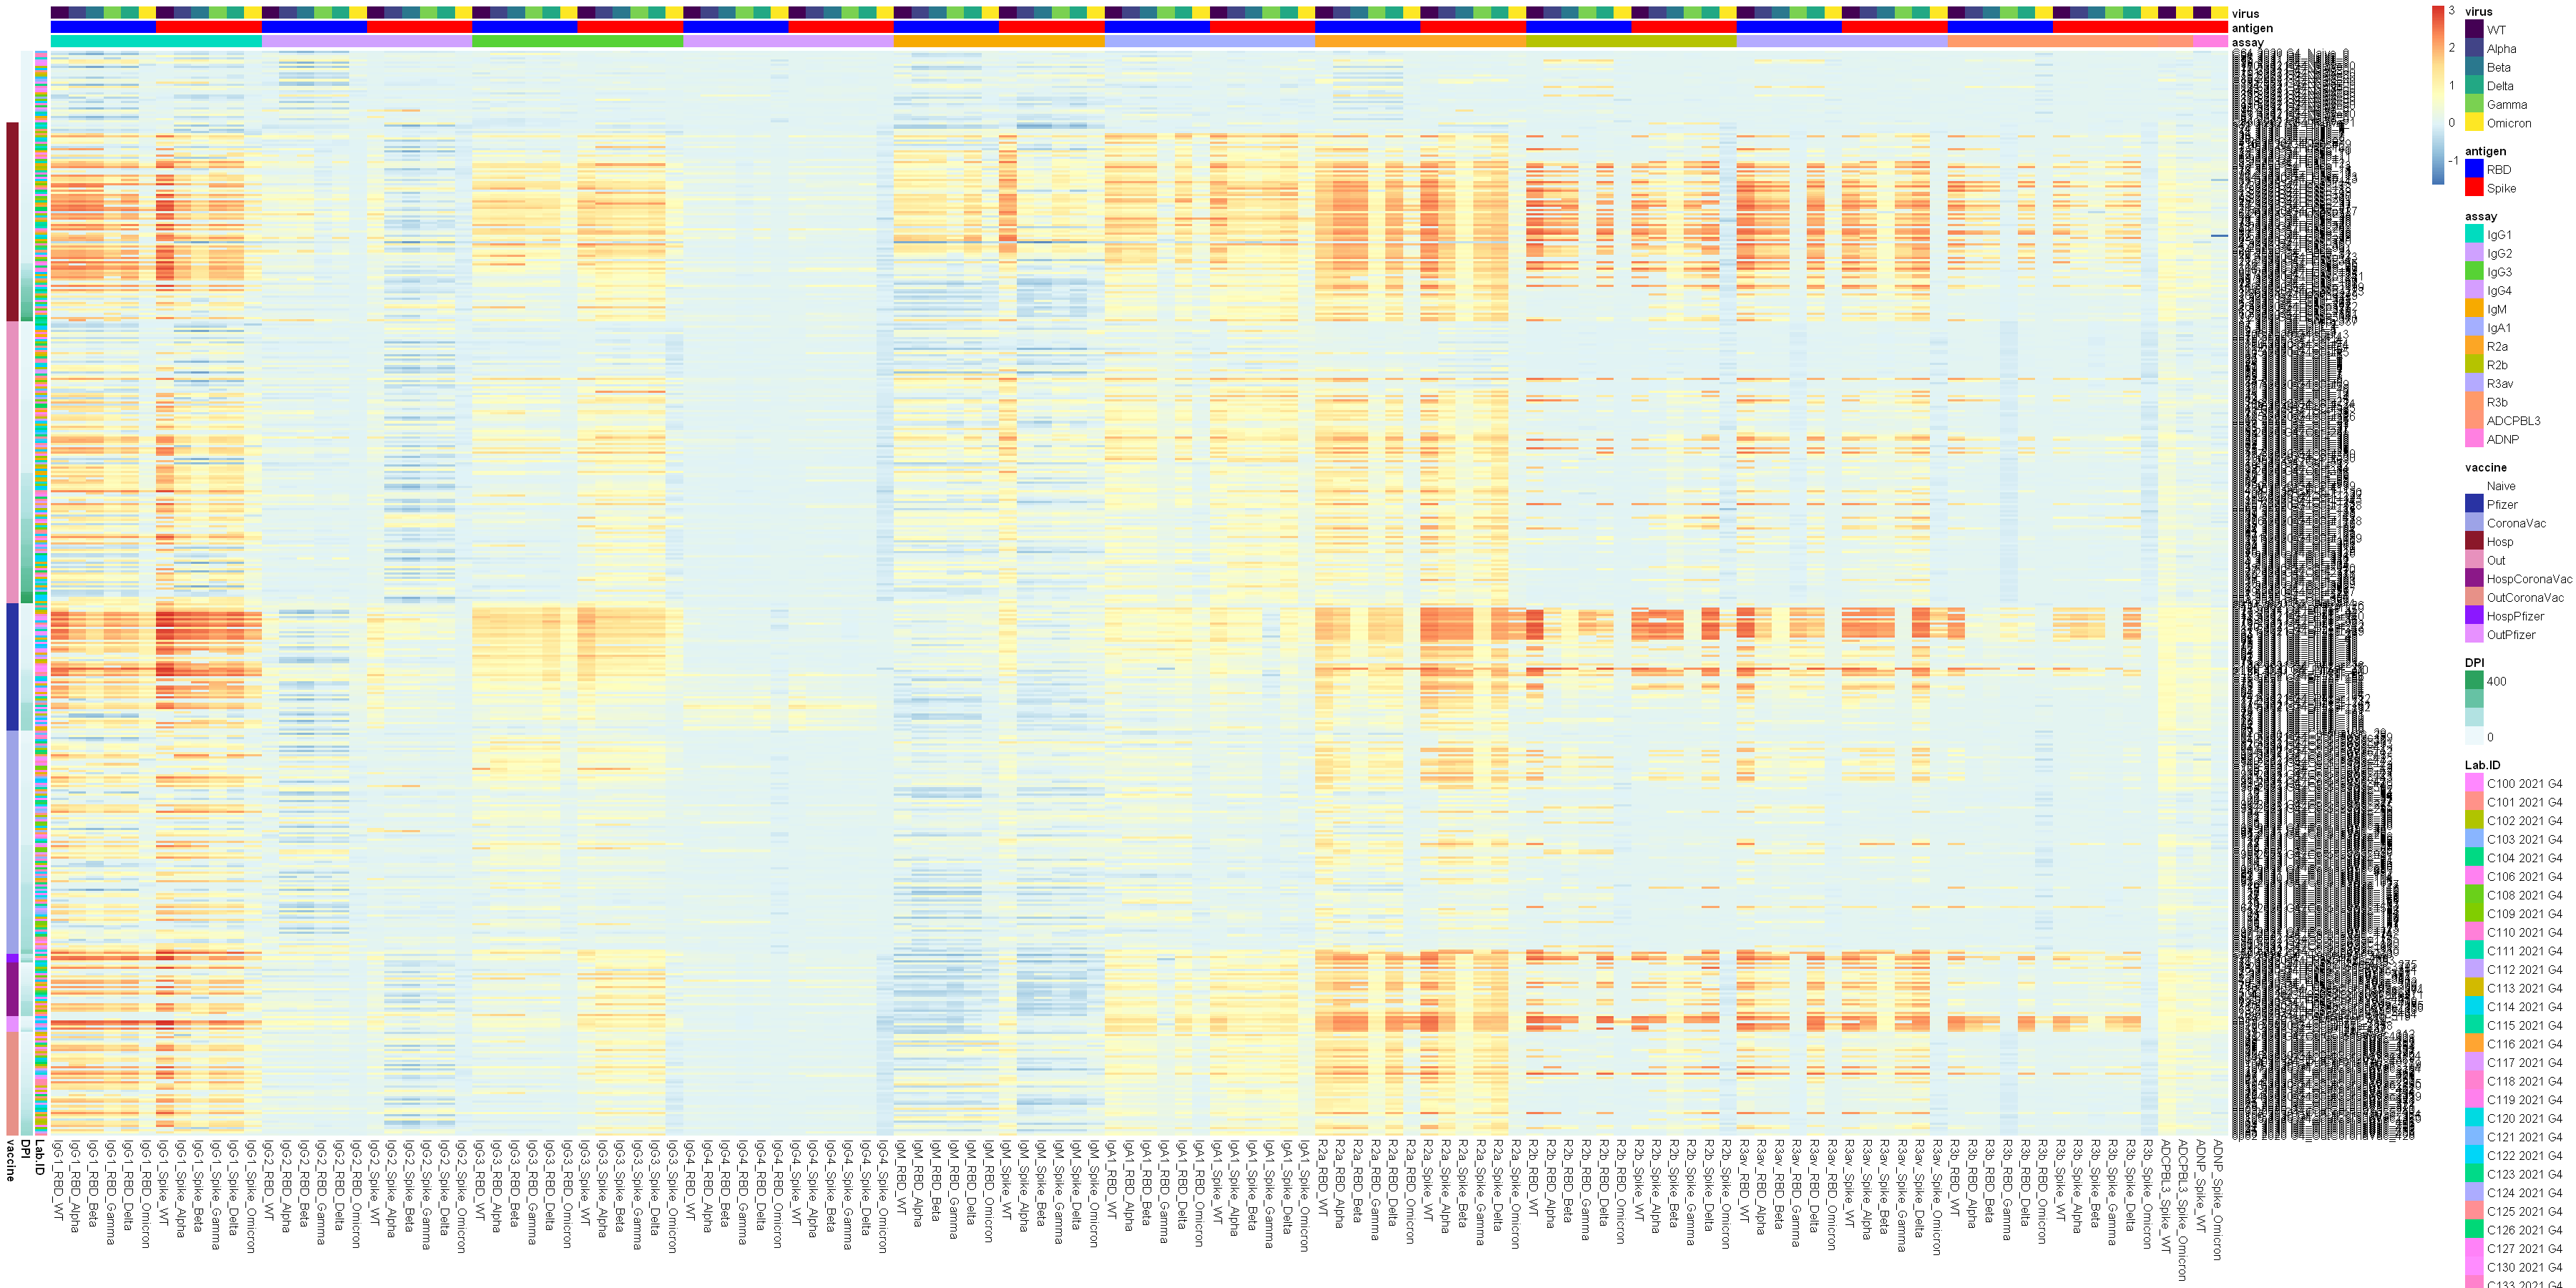

In [9]:
options(repr.plot.width=30, repr.plot.height=15)

all_data2 = all_data[,!grepl('Neut',colnames(all_data))]
idx = -c(1:6)
dat =     (log10(data.matrix(all_data2[,idx])))
dat[is.na(dat) | !is.finite(dat)]=0


cols = data.frame(do.call(rbind,strsplit( colnames(all_data2)[idx] , '_')) ) %>% rename(assay=X1,antigen=X2,virus=X3) %>%
    mutate(
        antigen = factor( as.character(antigen) , levels = c('N','NTD','RBD','S1','S2','Spike')),
        assay = factor( as.character(assay) , levels=c('IgG1','IgG2','IgG3','IgG4','IgM','IgA1','R2a','R2b','R3av','R3b','ADCPBL3','ADNP')),
        virus = factor(as.character(virus) , levels=c('WT' ,'Alpha','Beta','Gamma','Delta','Omicron')) #,'HKU1','OC43'))
        ) #%>% filter(!is.na(assay))

#%>% arrange( assay,antigen,virus)
rownames(cols) = colnames(dat)

cols = cols[ord<-order(cols$assay,cols$antigen,cols$virus),]

ph=pheatmap::pheatmap( dat[,ord],cluster_cols = F,cluster_rows=F,annotation_colors = colors,
    annotation_row = all_data2[,c(1,2,6)],
    annotation_col = cols
    )

pdf('../results/fig0.pdf',height=15,width=30)
  grid::grid.newpage()
  grid::grid.draw(ph$gtable)
dev.off()

In [10]:
dev.off()

null device 
          1

In [11]:
head(data_i)
dim(data_i)
colnames(data_decay_params)
dim( data_exp<-unique( merge(data_i,data_decay_params[,c('variable','antigen','virus','affinity','naive_2.5','naive_50','naive_97.5','naive_50_raw','naive_97.5_raw','naive_se')],all.x = T)))
head(data_decay_params)
head(data_exp)

,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,group,BOX,Lab.ID,Vaccine,...,DPFD,DPSD,DPTD,order,variable,antigen,virus,affinity,value,value_raw
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>
1,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.C1q,RBD,Alpha,C1q,1.2205047,2497.00
2,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgA1,RBD,Alpha,IgA1,0.6345194,4574.25
3,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG1,RBD,Alpha,IgG1,0.6033457,10216.00
4,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG2,RBD,Alpha,IgG2,0.2067241,3182.00
5,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG3,RBD,Alpha,IgG3,0.6672060,2886.50
6,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG4,RBD,Alpha,IgG4,0.9876875,2667.25


[1] 122670     22

[1] "vaccine"        "variable"       "antigen"        "virus"         
 [5] "affinity"       "model_type"     "n"              "hl"            
 [9] "hl_se"          "hl_t"           "I"              "I_se"          
[13] "I_t"            "Pr_t_I"         "Pr_t_hl"        "naive_2.5"     
[17] "naive_50"       "naive_97.5"     "naive_50_raw"   "naive_97.5_raw"
[21] "naive_se"

[1] 122670     28

,vaccine,variable,antigen,virus,affinity,model_type,n,hl,hl_se,hl_t,...,I_se,I_t,Pr_t_I,Pr_t_hl,naive_2.5,naive_50,naive_97.5,naive_50_raw,naive_97.5_raw,naive_se
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CoronaVac,Alpha.RBD.C1q,RBD,Alpha,C1q,lm,56,-0.0006143962,0.0003778246,-1.6261414,...,0.03347245,3.932596,0.0002415242,0.10974203,0.8514664,1,1.266710,2045.875,2591.531,231.7655
2,CoronaVac,Beta.RBD.C1q,RBD,Beta,C1q,lm,26,-0.0021294641,0.0010758594,-1.9793145,...,0.10114949,1.324682,0.1977525589,0.05936241,0.5184145,1,2.221973,28432.750,63176.800,15660.9760
3,CoronaVac,Delta.RBD.C1q,RBD,Delta,C1q,lm,56,-0.0005481919,0.0003786758,-1.4476548,...,0.03343946,3.283467,0.0018025685,0.15349477,0.8664983,1,1.226207,2227.500,2731.375,235.9695
4,CoronaVac,Gamma.RBD.C1q,RBD,Gamma,C1q,lm,52,-0.0005682394,0.0004135541,-1.3740390,...,0.03743789,1.162840,0.2504142590,0.17555816,0.5884511,1,1.376384,3883.500,5345.188,900.5460
5,CoronaVac,Omicron.RBD.C1q,RBD,Omicron,C1q,lm,47,0.0005809210,0.0007403875,0.7846174,...,0.06738418,-3.688259,0.0006060414,0.43678906,0.5941412,1,1.404198,545335.250,765758.594,133732.5325
6,CoronaVac,WT.RBD.C1q,RBD,WT,C1q,lm,54,-0.0008508566,0.0008010399,-1.0621900,...,0.06917320,3.116501,0.0029783152,0.29305770,0.9023562,1,1.250513,1716.250,2146.194,170.5627


,variable,antigen,virus,affinity,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,...,DPTD,order,value,value_raw,naive_2.5,naive_50,naive_97.5,naive_50_raw,naive_97.5_raw,naive_se
,<chr>,<chr>,<fct>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alpha.RBD.C1q,RBD,Alpha,C1q,3,171,3,A3,CoronaVac2,CoronaVac,...,NA,341.5,1.3418464,2745.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
5,Alpha.RBD.C1q,RBD,Alpha,C1q,64,484,6,F4,Out-3,Out,...,NA,967.5,1.2125529,2936.50,0.8514664,1,1.26671,2045.875,2591.531,231.7655
9,Alpha.RBD.C1q,RBD,Alpha,C1q,14,266,4,B2,Hosp-1,Hosp,...,NA,531.5,1.0502736,2543.50,0.8514664,1,1.26671,2045.875,2591.531,231.7655
13,Alpha.RBD.C1q,RBD,Alpha,C1q,35,119,2,C11,CoronaVac,CoronaVac,...,NA,237.5,0.9469054,1937.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
17,Alpha.RBD.C1q,RBD,Alpha,C1q,70,490,6,F10,OutCoronaVac-2-3,OutCoronaVac,...,91,979.5,1.0654485,2580.25,0.8514664,1,1.26671,2045.875,2591.531,231.7655
21,Alpha.RBD.C1q,RBD,Alpha,C1q,23,23,1,B11,Pfizer,Pfizer,...,NA,45.5,1.0709354,2191.00,0.8514664,1,1.26671,2045.875,2591.531,231.7655


In [12]:
# options(repr.plot.width=20, repr.plot.height=15)

# head(data_i)
# data_i %>% arrange(Lab.ID,DPFD) %>% group_by(Lab.ID) %>% 
#     mutate(
#         DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T)),
#         # first_dose = which.min(DPTD - DPFD),
#         Vaccine = vaccine[length(vaccine)] #[which.max(nchar(Vaccine))]
#         # DPFI = if_else(is.na(DPTD),DPFD-min(DPTD,na.rm=T),DPTD)
#     )%>%
#     filter(variable=='WT.Spike.IgG1' & group%in%c('C','o','p')[2:3] & !Vaccine%in%c('Out','Hosp')) %>% droplevels() %>%
#         ggplot(aes(x=DPFI,y=value,color=Vaccine))+
#             geom_line(aes(group=Lab.ID),color='black',alpha=.9)+
#             stat_smooth(se=T,size=2)+
#             theme_bw(base_size=20)+
#             # geom_text(aes(label=first_dose))+
#             # theme(legend.position = 'none')+
#             scale_y_log10()+#scale_x_log10()+
#             facet_wrap(~Vaccine,nrow=2)

In [13]:
# options(repr.plot.width=25, repr.plot.height=15)

# head(data_i)
# data_i %>% arrange(Lab.ID,DPFD) %>% group_by(Lab.ID) %>% 
#     mutate(
#         DPFI = if_else(is.na(DPTD),DPFD,DPTD)
#         # Vaccine = vaccine[length(vaccine)] #[which.max(nchar(Vaccine))]
#         # DPFI = if_else(is.na(DPTD),DPFD-min(DPTD,na.rm=T),DPTD)
#     )%>%
#     filter(variable=='WT.Spike.IgG1' & group%in%c('C','o','p')[1:3] & !vaccine%in%c('Naive','CoronaVac2+Pfizer') ) %>% droplevels() %>%
#         ggplot(aes(x=DPFI,y=value,color=vaccine))+
#             stat_smooth(se=F,size=2)+
# geom_point(color='black')+
#             geom_line(aes(group=Lab.ID),color='black',alpha=.9)+
#             theme_bw(base_size=20)+
#             # theme(legend.position = 'none')+
#             scale_y_log10()+facet_wrap(~vaccine,nrow=2)

,PlateNum,SampleNum,PlateID,PlateCoord,ID,vaccine,group,BOX,Lab.ID,Vaccine,...,DPFD,DPSD,DPTD,order,variable,antigen,virus,affinity,value,value_raw
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,...,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>
1,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.C1q,RBD,Alpha,C1q,1.2205047,2497.00
2,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgA1,RBD,Alpha,IgA1,0.6345194,4574.25
3,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG1,RBD,Alpha,IgG1,0.6033457,10216.00
4,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG2,RBD,Alpha,IgG2,0.2067241,3182.00
5,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG3,RBD,Alpha,IgG3,0.6672060,2886.50
6,1,1,1,A1,Naive,Naive,C,1,C64 2020 G4,Naive,...,NA,NA,NA,1.5,Alpha.RBD.IgG4,RBD,Alpha,IgG4,0.9876875,2667.25


`summarise()` has grouped output by 'Lab.ID', 'vaccine', 'variable'. You can override using the `.groups` argument.


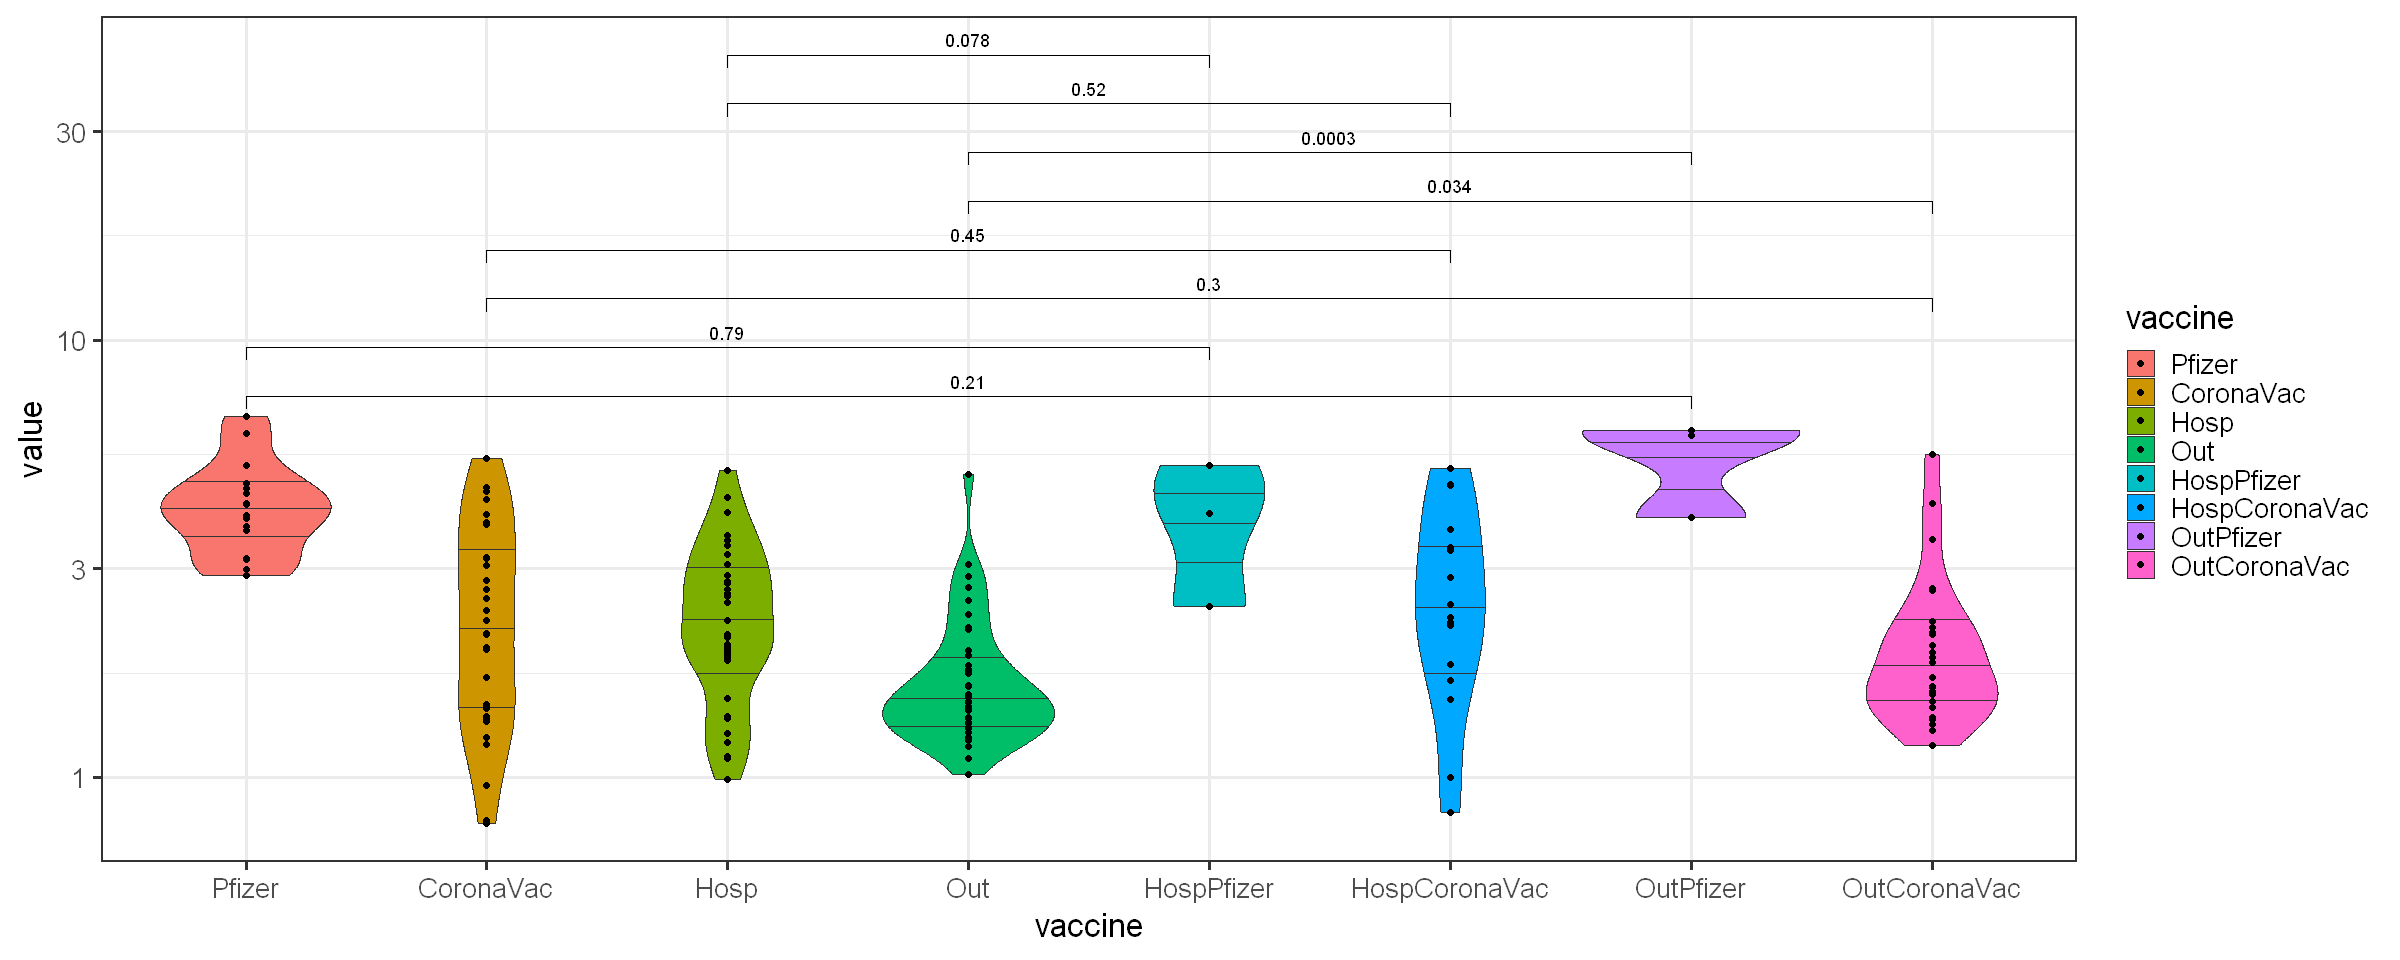

In [14]:
options(repr.plot.width=20, repr.plot.height=8)

head(data_i)
data_i %>% arrange(Lab.ID,DPFD) %>% group_by(Lab.ID,vaccine,variable,group) %>% 
    summarise(
        value=max(value)
    )%>%
    mutate(vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))) %>%
    filter(variable=='WT.Spike.ADNP' & group%in%c('C','o','p')[1:3] & !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine)) %>% droplevels() %>%
        ggplot(aes(x=vaccine,y=value,fill=vaccine))+
            geom_violin(draw_quantiles = c(.25,.5,.75))+
            geom_point()+
            theme_bw(base_size=20)+
stat_compare_means(comparisons = list(
    c('Pfizer','OutPfizer'),c('Pfizer','HospPfizer'),
      c('CoronaVac','OutCoronaVac'),c('CoronaVac','HospCoronaVac'),
      c('Out','OutCoronaVac'),c('Out','OutPfizer'),
      c('Hosp','HospCoronaVac'),c('Hosp','HospPfizer')
  ))+
            # theme(legend.position = 'none')+
            scale_y_log10()#+facet_wrap(~vaccine,nrow=2)

# Screen all variables

In [15]:
dim( data_exp<-unique( merge(data_i,data_decay_params[,c('variable','antigen','virus','affinity','naive_2.5','naive_50','naive_97.5','naive_50_raw','naive_97.5_raw','naive_se')],all.x = T)))

[1] 122670     28

In [16]:
tmp=data_exp %>% arrange(Lab.ID,DPFD) %>% 
    mutate(
                DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T))
    ) %>%
    filter(
        DPFI>0
    ) %>%
    group_by(Lab.ID,
             vaccine,antigen,affinity,virus,
             variable,group) %>% 
        summarise(
            value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , value[ which.max(DPFD) ] ),  #  min(value,na.rm=T)),
            naive_97.5 = (unique(naive_97.5)),
            # value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
            value_max = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , max(value,na.rm=T))
            ###### which wane/boost events break naivety?
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)], #[which.max(nchar(Vaccine))]
            vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))
        ) %>% 
    filter(#variable=='Omicron.Spike.IgG1' & 
           group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine) 
          ) %>% droplevels() %>% unique()

head(tmp)

Warning message:
"There were 2277 warnings in `summarise()`.
The first warning was:
i In argument: `value_minmax = if_else(...)`.
i In group 278: `Lab.ID = "C100 2021 G4"`, `vaccine = "CoronaVac2+Pfizer"`, `antigen = "N"`, `affinity = "R3av"`,
  `virus = WT`, `variable = "WT.N.R3av"`, `group = "C"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
i Run `dplyr::last_dplyr_warnings()` to see the 2276 remaining warnings."
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
i Please use `reframe()` instead.
i When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly."
`summarise()` has grouped output by 'Lab.ID', 'vaccine', 'antigen', 'affinity', 'virus', 'variable', 'group'. You can
override using the `.groups` argument.


Lab.ID,vaccine,antigen,affinity,virus,variable,group,value_minmax,naive_97.5,value_max,vaccine2
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
op1 2020 G4,Out,Antigen,C1q,NA,EBOV.Antigen.C1q,o,1.3495146,NA,1.3495146,OutCoronaVac
op1 2020 G4,Out,Antigen,C1q,NA,HCMVgB.Antigen.C1q,o,1.3101971,NA,1.3101971,OutCoronaVac
op1 2020 G4,Out,Antigen,IgA1,NA,EBOV.Antigen.IgA1,o,0.9361272,NA,1.0118621,OutCoronaVac
op1 2020 G4,Out,Antigen,IgA1,NA,HCMVgB.Antigen.IgA1,o,1.7671624,NA,2.0371586,OutCoronaVac
op1 2020 G4,Out,Antigen,IgG1,NA,EBOV.Antigen.IgG1,o,0.8241813,NA,0.9985941,OutCoronaVac
op1 2020 G4,Out,Antigen,IgG1,NA,HCMVgB.Antigen.IgG1,o,0.1495500,NA,0.1841200,OutCoronaVac


## measure stats

In [17]:
get_i = function(tmpi,x){
    i = unique(as.character(tmpi[[x]]))
    ifelse( length(i)>0 , i , '' )
}

stats=do.call(plyr::rbind.fill, lapply(rev(grep('WT|Delta|Gamma|Omicron',unique(tmp$variable),value=T)) , function(vi){
    do.call(plyr::rbind.fill, lapply(unique(tmp$vaccine2),function(v2){
        tmpi=tmp %>% 
            filter( vaccine2==v2 & variable==vi ) %>%
            arrange(vaccine,Lab.ID) %>% unique() %>% na.omit() %>% droplevels()
        tab = table(tmpi$Lab.ID)
        tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2])
        out=data.frame(statistic=NA,v2=v2,vi=vi)

        # val1=tmpi$value_max[tmpi$vaccine==unique(tmpi$vaccine)[2]]
        # val2=tmpi$value_max[tmpi$vaccine==unique(tmpi$vaccine)[1]]
        # md1_max = median(val1)
        # md2_max = median(val2)
        # diff_max = median(val1-val2)

        
        val1=tmpi$value_minmax[tmpi$vaccine==unique(tmpi$vaccine)[2]]+.1 # new psuedocounts
        val2=tmpi$value_minmax[tmpi$vaccine==unique(tmpi$vaccine)[1]]+.1

        #clear inf values (new)
        val1=ifelse(!is.finite(val1),NA,val1)
        val2=ifelse(!is.finite(val1),NA,val2)

        v12 = na.omit(cbind(val1,val2))
        val1=v12[,1]
        val2=v12[,2]

        # print(val1)
        # print(val2)
        
        md1_minmax = median(val1,na.rm=T)
        md2_minmax = median(val2,na.rm=T)
        diff_minmax = median(val1-val2,na.rm=T)
        diff_minmax = ifelse(diff_minmax<.1,.1,diff_minmax) # new
        
        # print(val1)
        # print(val2)
        # print( str(summary(aov(value_minmax ~ vaccine,data=tmpi))[[1]]['Pr(>F)'][[1]][1]) )
        
        antigen = get_i(tmpi,'antigen');affinity = get_i(tmpi,'affinity');virus = get_i(tmpi,'virus')

        try(out<-as.data.frame( #rbind(
                                    cbind(v2,vi,antigen,affinity,virus,type='minmax',naive_97.5=unique(tmpi$naive_97.5),
                                          broom::tidy(t.test(log(val2),log(val1),data = tmpi,alternative = 'less',paired = T)) ,
                                          md1=md1_minmax,md2=md2_minmax,diff=diff_minmax, 
                                          group1=unique(tmpi$vaccine)[2],group2=unique(tmpi$vaccine)[1],
                                          t_p = broom::tidy(t.test(log(val2),log(val1),data = tmpi,alternative = 'less',paired=T))$p.value 
                                          # aov_p = summary(aov(value_minmax ~ vaccine,data=tmpi))[[1]]['Pr(>F)'][[1]][1]#,
                                          # NA
                                         ) #,
                                    # cbind(broom::tidy())
                                    # cbind(v2,vi,antigen,affinity,virus,type='max',
                                    #  broom::tidy(wilcox.test(log(value_max)~vaccine,data = tmpi,alternative = 'less',paired = T)),
                                    #       md1=md1_max,md2=md2_max,diff=diff_max)
        ))
        out
        # print(out)
        # stop()
})) #; stop()
})) %>% 
    # rename('.y.'='type') %>%
    unique() #%>% na.omit()


Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",  : 
  not enough 'x' observations
Error in t.test.default(log(val2), log(val1), data = tmpi, alternative = "less",

In [18]:
stats %>% filter(antigen=='Spike' & virus%in%c('WT','Omicron') & affinity%in%c('IgG1','R2a','ADNP','ADCPBL3'))


v2,vi,antigen,affinity,virus,type,naive_97.5,estimate,statistic,p.value,...,conf.low,conf.high,method,alternative,md1,md2,diff,group1,group2,t_p
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
OutCoronaVac,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.079551317,-1.94289311,3.168601e-02,...,-Inf,-0.009611882,Paired t-test,less,1.476570,1.419621,0.1013563,OutCoronaVac,Out,3.168601e-02
OutPfizer,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.958584518,-7.44640431,8.780478e-03,...,-Inf,-0.582691288,Paired t-test,less,2.801703,1.321318,1.6177534,OutPfizer,Out,8.780478e-03
HospCoronaVac,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.082276629,-1.52118294,7.523760e-02,...,-Inf,0.012987824,Paired t-test,less,1.580894,1.476036,0.1414850,HospCoronaVac,Hosp,7.523760e-02
HospPfizer,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.357224525,-7.95213022,3.981924e-02,...,-Inf,-0.073599028,Paired t-test,less,2.422317,1.688050,0.7342670,HospPfizer,Hosp,3.981924e-02
OutCoronaVac,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-0.635042740,-3.22951577,1.787755e-03,...,-Inf,-0.298619783,Paired t-test,less,11.297837,7.538827,5.2263592,OutCoronaVac,Out,1.787755e-03
OutPfizer,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-4.159794356,-12.21518286,3.317651e-03,...,-Inf,-3.165413864,Paired t-test,less,268.184942,4.531882,261.0084828,OutPfizer,Out,3.317651e-03
HospCoronaVac,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-0.359488290,-1.66341498,6.006787e-02,...,-Inf,0.023236300,Paired t-test,less,52.502163,22.355394,8.4949331,HospCoronaVac,Hosp,6.006787e-02
HospPfizer,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-1.182904332,-1.56083913,1.813718e-01,...,-Inf,3.602062851,Paired t-test,less,193.395502,86.787617,106.6078850,HospPfizer,Hosp,1.813718e-01
OutCoronaVac,Omicron.Spike.IgG1,Spike,IgG1,Omicron,minmax,1.556199,-0.253199712,-2.71704919,5.891668e-03,...,-Inf,-0.094019396,Paired t-test,less,3.518748,2.397964,0.3372945,OutCoronaVac,Out,5.891668e-03


In [19]:
write.csv(stats,'../data-final/stats_paired.boost.csv')

In [20]:
stats = read.csv('../data-final/stats_paired.boost.csv',row.names = 1)

In [21]:
stats %>% filter(antigen=='Spike' & virus%in%c('WT','Omicron') & affinity%in%c('IgG1','R2a','ADNP','ADCPBL3'))
# p104 2020 G4	OutCoronaVac	Spike	IgG1	WT	WT.Spike.IgG1

v2,vi,antigen,affinity,virus,type,naive_97.5,estimate,statistic,p.value,...,conf.low,conf.high,method,alternative,md1,md2,diff,group1,group2,t_p
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
OutCoronaVac,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.079551317,-1.94289311,3.168601e-02,...,-Inf,-0.009611882,Paired t-test,less,1.476570,1.419621,0.1013563,OutCoronaVac,Out,3.168601e-02
OutPfizer,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.958584518,-7.44640431,8.780478e-03,...,-Inf,-0.582691288,Paired t-test,less,2.801703,1.321318,1.6177534,OutPfizer,Out,8.780478e-03
HospCoronaVac,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.082276629,-1.52118294,7.523760e-02,...,-Inf,0.012987824,Paired t-test,less,1.580894,1.476036,0.1414850,HospCoronaVac,Hosp,7.523760e-02
HospPfizer,Omicron.Spike.R2a,Spike,R2a,Omicron,minmax,1.861207,-0.357224525,-7.95213022,3.981924e-02,...,-Inf,-0.073599028,Paired t-test,less,2.422317,1.688050,0.7342670,HospPfizer,Hosp,3.981924e-02
OutCoronaVac,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-0.635042740,-3.22951577,1.787755e-03,...,-Inf,-0.298619783,Paired t-test,less,11.297837,7.538827,5.2263592,OutCoronaVac,Out,1.787755e-03
OutPfizer,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-4.159794356,-12.21518286,3.317651e-03,...,-Inf,-3.165413864,Paired t-test,less,268.184942,4.531882,261.0084828,OutPfizer,Out,3.317651e-03
HospCoronaVac,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-0.359488290,-1.66341498,6.006787e-02,...,-Inf,0.023236300,Paired t-test,less,52.502163,22.355394,8.4949331,HospCoronaVac,Hosp,6.006787e-02
HospPfizer,WT.Spike.R2a,Spike,R2a,WT,minmax,1.426075,-1.182904332,-1.56083913,1.813718e-01,...,-Inf,3.602062851,Paired t-test,less,193.395502,86.787617,106.6078850,HospPfizer,Hosp,1.813718e-01
OutCoronaVac,Omicron.Spike.IgG1,Spike,IgG1,Omicron,minmax,1.556199,-0.253199712,-2.71704919,5.891668e-03,...,-Inf,-0.094019396,Paired t-test,less,3.518748,2.397964,0.3372945,OutCoronaVac,Out,5.891668e-03


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 19 rows containing non-finite outside the scale range (`stat_bin()`)."


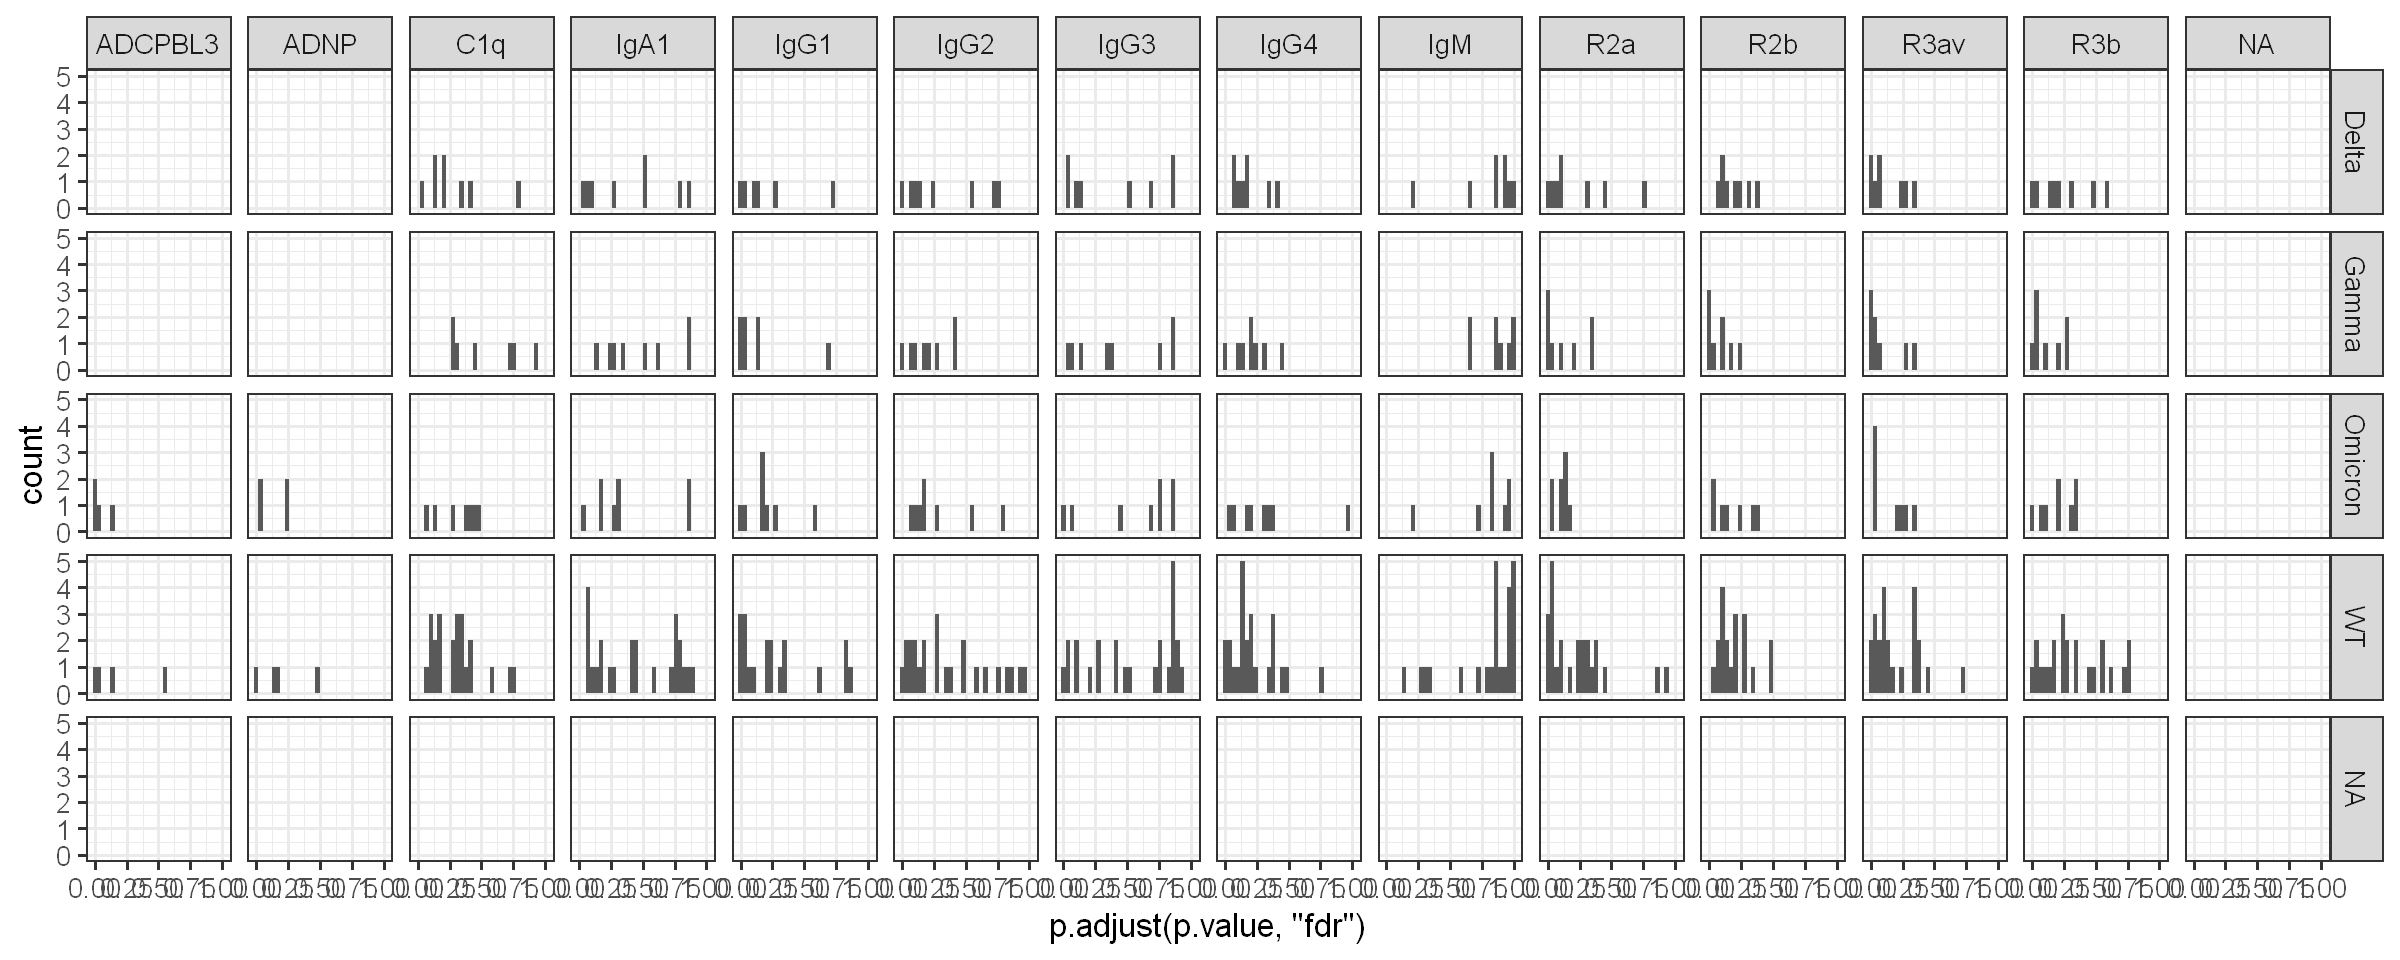

In [22]:
stats %>% ggplot(aes(x=p.adjust(p.value,'fdr')))+geom_histogram()+facet_grid(virus~affinity)+theme_bw(base_size=20)

In [23]:
# head(stats)

# options(repr.plot.width=25, repr.plot.height=8)

# out=list()
# for(virusi in c('WT','Alpha','Beta','Delta','Gamma','Omicron')){
#     si=stats %>% 
#         filter(!is.na(type) & virus==virusi & grepl('CoronaVac',v2) & type=='minmax') %>%
#         mutate(
#             virus = factor(as.character(virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43')),
#             affinity = factor(as.character(affinity),levels=c('IgM','IgG1','IgG2','IgG3','IgG4','IgA1','R2a','R2b','R3av','R3b','C1q','ADCD','ADCPBL2','ADCPBL3','ADNP'))
#         ) %>% droplevels() %>%
#         ggplot(aes(color=v2,x=affinity,
#                    alpha=ifelse(p.adjust(p.value,'fdr')<0.1,1,.1)))+
#                    # alpha=ifelse(p.adjust(p.value,'fdr')<0.1,1,.1)))+
#             geom_pointrange(aes(y=md1,ymin=md1,ymax=md1+abs(diff)),position=position_dodge(width=.5))+
#             theme_bw(base_size=20)+
#      theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
#             # scale_y_log10()+
#             labs(alpha='FDR<0.1')+
#             facet_grid(type~antigen)+ggtitle(virusi)
#     print(si)
#     out[[virusi]]=si
# }



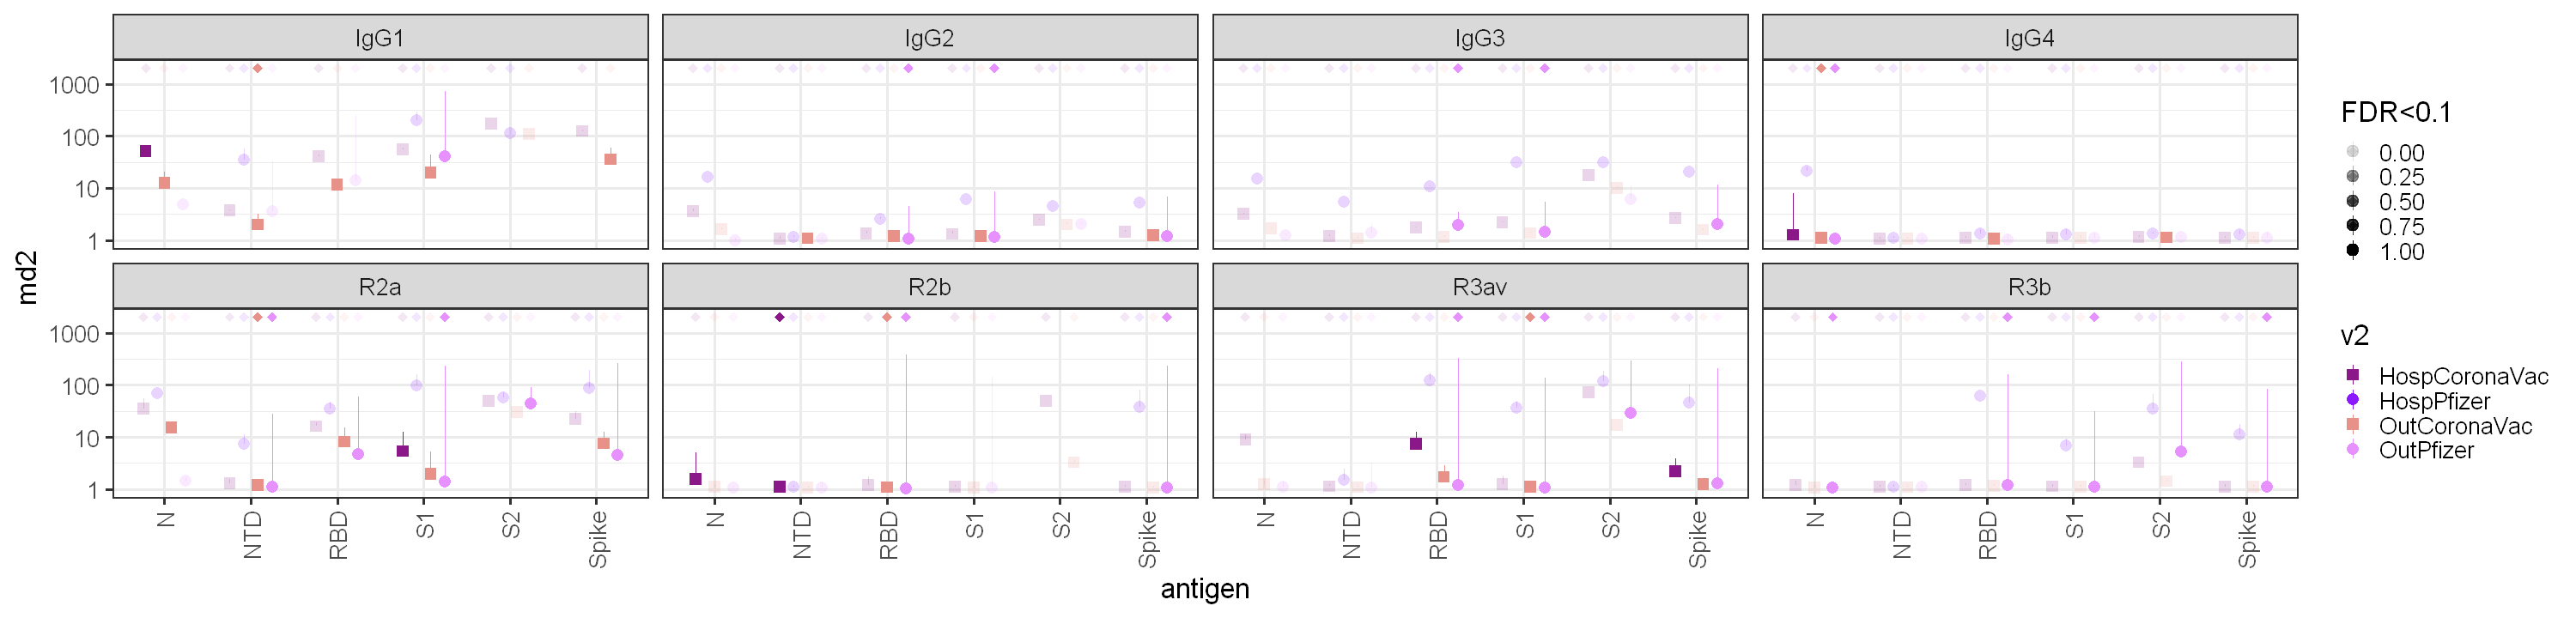

In [24]:
options(repr.plot.width=25, repr.plot.height=6)


col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF')

out=list()
# for(virusi in c('WT','Alpha','Beta','Delta','Gamma','Omicron')){
    stats %>% 
        filter(!is.na(type) & virus=='WT' & #grepl('CoronaVac',v2) & 
                affinity %in% c('IgG1','IgG2','IgG3','IgG4','R2a','R2b','R3av','R3b') &
               type=='minmax') %>%
        mutate(
            virus = factor(as.character(virus) , levels=c('WT' ,'Alpha','Beta','Delta','Gamma','Omicron','HKU1','OC43')),
            affinity = factor(as.character(affinity),levels=c('IgM','IgG1','IgG2','IgG3','IgG4','IgA1','R2a','R2b','R3av','R3b','C1q','ADCD','ADCPBL2','ADCPBL3','ADNP'))
        ) %>% droplevels() %>%
        ggplot(aes(color=v2,x=antigen,shape=v2,
                   # alpha=ifelse(p.adjust(p.value,'fdr')<0.1 & md2>naive_97.5,1,.1)))+
                   alpha=ifelse(p.adjust(p.value,'fdr')<0.1,1,.1)))+
            geom_pointrange(aes(y=md2,ymin=md2,ymax=md2+(diff)),position=position_dodge(width=.65),size=.8)+
            geom_point(aes(y=2e3,
                           # alpha=ifelse( p.adjust(p.value,'fdr')<0.1,1,0)),
                           alpha = ifelse( p.adjust(p.value,'fdr')<0.1 & (md1*1.1)>naive_97.5 & (md2*0.9)<naive_97.5 , 1,0)),
                           # shape=ifelse( p.adjust(p.value,'fdr')<0.1,18,4)),
                       position=position_dodge(width=.65),size=3,shape=18)+
            theme_bw(base_size=20)+
            theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
            scale_color_manual(values = col[5:8])+
            scale_y_log10()+
            labs(alpha='FDR<0.1')+
            scale_shape_manual(values = c(15,16,15,16))+
            facet_wrap(~affinity,nrow=2)


ggsave('../results//05_boost/subdomains.pdf',width=25,height=10)
ggsave('../results/figS5a.pdf',width=25,height=10)



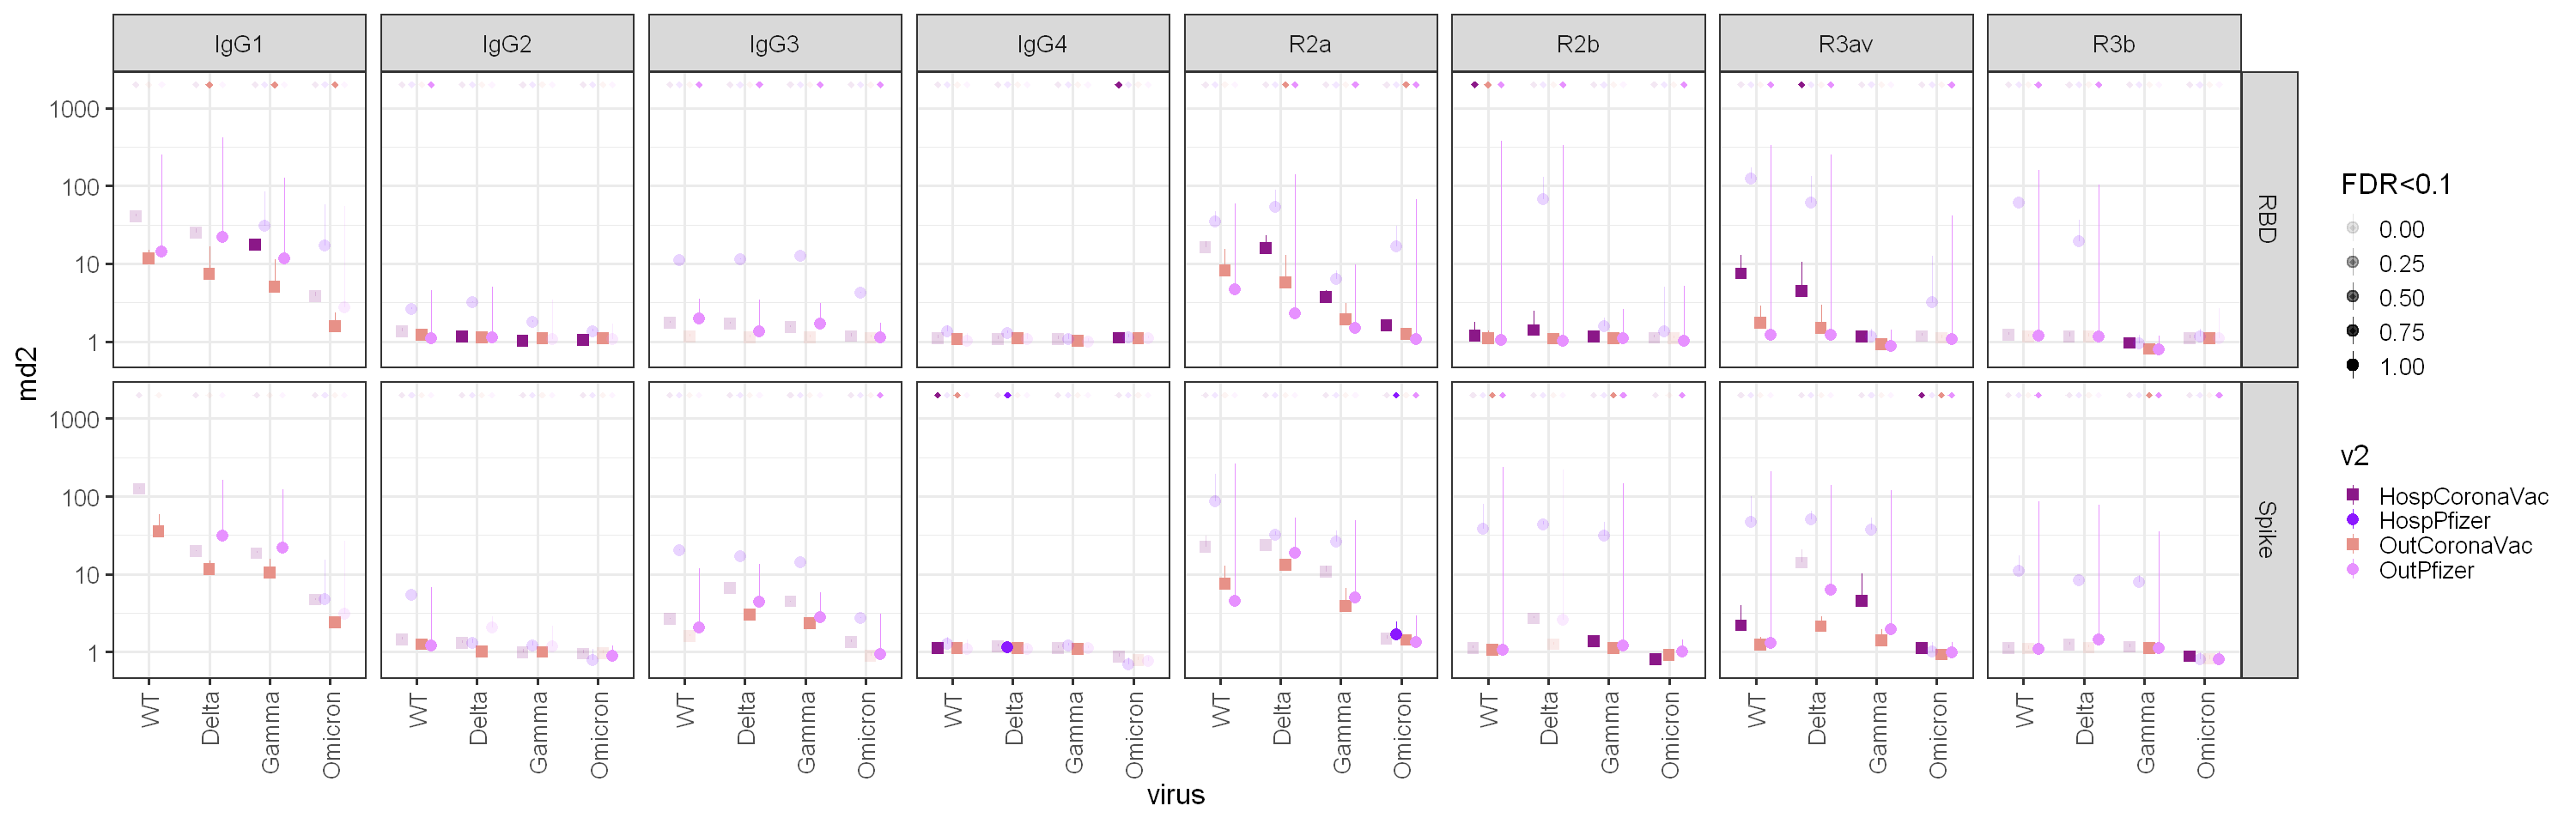

In [25]:
options(repr.plot.width=25, repr.plot.height=8)


stats %>% 
    mutate(
        virus = factor(as.character(virus) , levels=c('WT' ,'Delta','Gamma','Omicron','HKU1','OC43')),
        affinity = factor(as.character(affinity),levels=c('IgG1','IgG2','IgG3','IgG4','R2a','R2b','R3av','R3b')) #,'ADCD','ADCPBL2','ADCPBL3','ADNP'))
    ) %>% droplevels() %>%
    filter(!is.na(type)  &!is.na(virus) & !is.na(affinity)  & #grepl('CoronaVac',v2) &
           type=='minmax' & antigen%in%c('Spike','RBD') &
          virus %in% c('WT','Alpha','Beta','Delta','Gamma','Omicron')) %>%
    ggplot(aes(color=v2,shape=v2,x=virus,
               alpha=ifelse(p.adjust(p.value,'fdr')<0.1 ,1,.1)))+
               # alpha=ifelse(p.adjust(p.value,'fdr')<0.1 & diff/md2 > .1,1,.1)))+
        geom_pointrange(aes(y=md2,ymin=md2,ymax=md2+diff),position=position_dodge(width=.65),size=.8)+
            geom_point(aes(y=2e3,
                           alpha = ifelse( p.adjust(p.value,'fdr')<0.1 & (md1*1.1)>naive_97.5 & (md2*0.9)<naive_97.5 , 1,0)),
                       shape=18,position=position_dodge(width=.65),size=2)+
        theme_bw(base_size=20)+
        scale_color_manual(values = col[5:8])+
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
        labs(alpha='FDR<0.1')+
            scale_shape_manual(values = c(15,16,15,16))+
        scale_y_log10()+
        facet_grid(antigen~affinity)#+ggtitle(virusi)

ggsave('../results//05_boost/VOCs.pdf',width=25,height=8)
ggsave('../results/figS5b.pdf',width=25,height=10)


# Boosting is not time dependent

In [26]:
options(repr.plot.width=25, repr.plot.height=8)


tmp=data_i %>% arrange(Lab.ID,DPFD) %>% 
    mutate(
                DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T)),
        DoFD = DPFD-DPTD,
        DoSD = DPFD-DPSD
    ) %>%
    filter(
        # !grepl('^EBOV|^HCMV|^Influenza',variable)
        DPFD>0
    ) %>%
    group_by(Lab.ID,
             vaccine,antigen,affinity,virus,
             variable,group) %>% 
        summarise(
            value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , value[ which.max(DPFD) ] ),  #  min(value,na.rm=T)),
            # value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
            value_max = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , max(value,na.rm=T)),
            DoFD = unique(c(DoFD,NA))[1],
            DoSD = unique(c(DoSD,NA))[1]
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)], #[which.max(nchar(Vaccine))]
            vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))
        ) %>% 
    filter(     
           group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine) 
          ) %>% droplevels()

head(tmp %>% filter(vaccine%in%c('OutCoronaVac') & variable=='WT.Spike.IgG1')) #%>% select(vaccine,group,Lab.ID,variable,DoFD,DoSD),n=20)

Warning message:
"There were 2277 warnings in `summarise()`.
The first warning was:
i In argument: `value_minmax = if_else(...)`.
i In group 278: `Lab.ID = "C100 2021 G4"`, `vaccine = "CoronaVac2+Pfizer"`, `antigen = "N"`, `affinity = "R3av"`,
  `virus = WT`, `variable = "WT.N.R3av"`, `group = "C"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
i Run `dplyr::last_dplyr_warnings()` to see the 2276 remaining warnings."
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
i Please use `reframe()` instead.
i When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly."
`summarise()` has grouped output by 'Lab.ID', 'vaccine', 'antigen', 'affinity', 'virus', 'variable', 'group'. You can
override using the `.groups` argument.


Lab.ID,vaccine,antigen,affinity,virus,variable,group,value_minmax,value_max,DoFD,DoSD,vaccine2
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
op1 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,40.09000,40.09000,378,350,OutCoronaVac
op100 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,38.44414,38.44414,155,127,OutCoronaVac
op100 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,38.44414,38.44414,155,127,OutCoronaVac
op101 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,-Inf,-Inf,253,225,OutCoronaVac
op104 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,48.87950,48.87950,NA,151,OutCoronaVac
op104 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,48.87950,48.87950,NA,151,OutCoronaVac


Warning message in glm.fit(x = structure(numeric(0), .Dim = c(0L, 2L), .Dimnames = list(:
"no observations informative at iteration 1"
Warning message:
"glm.fit: algorithm did not converge"


Error in glm.fit(x = structure(numeric(0), .Dim = c(0L, 2L), .Dimnames = list( : 
  object 'fit' not found


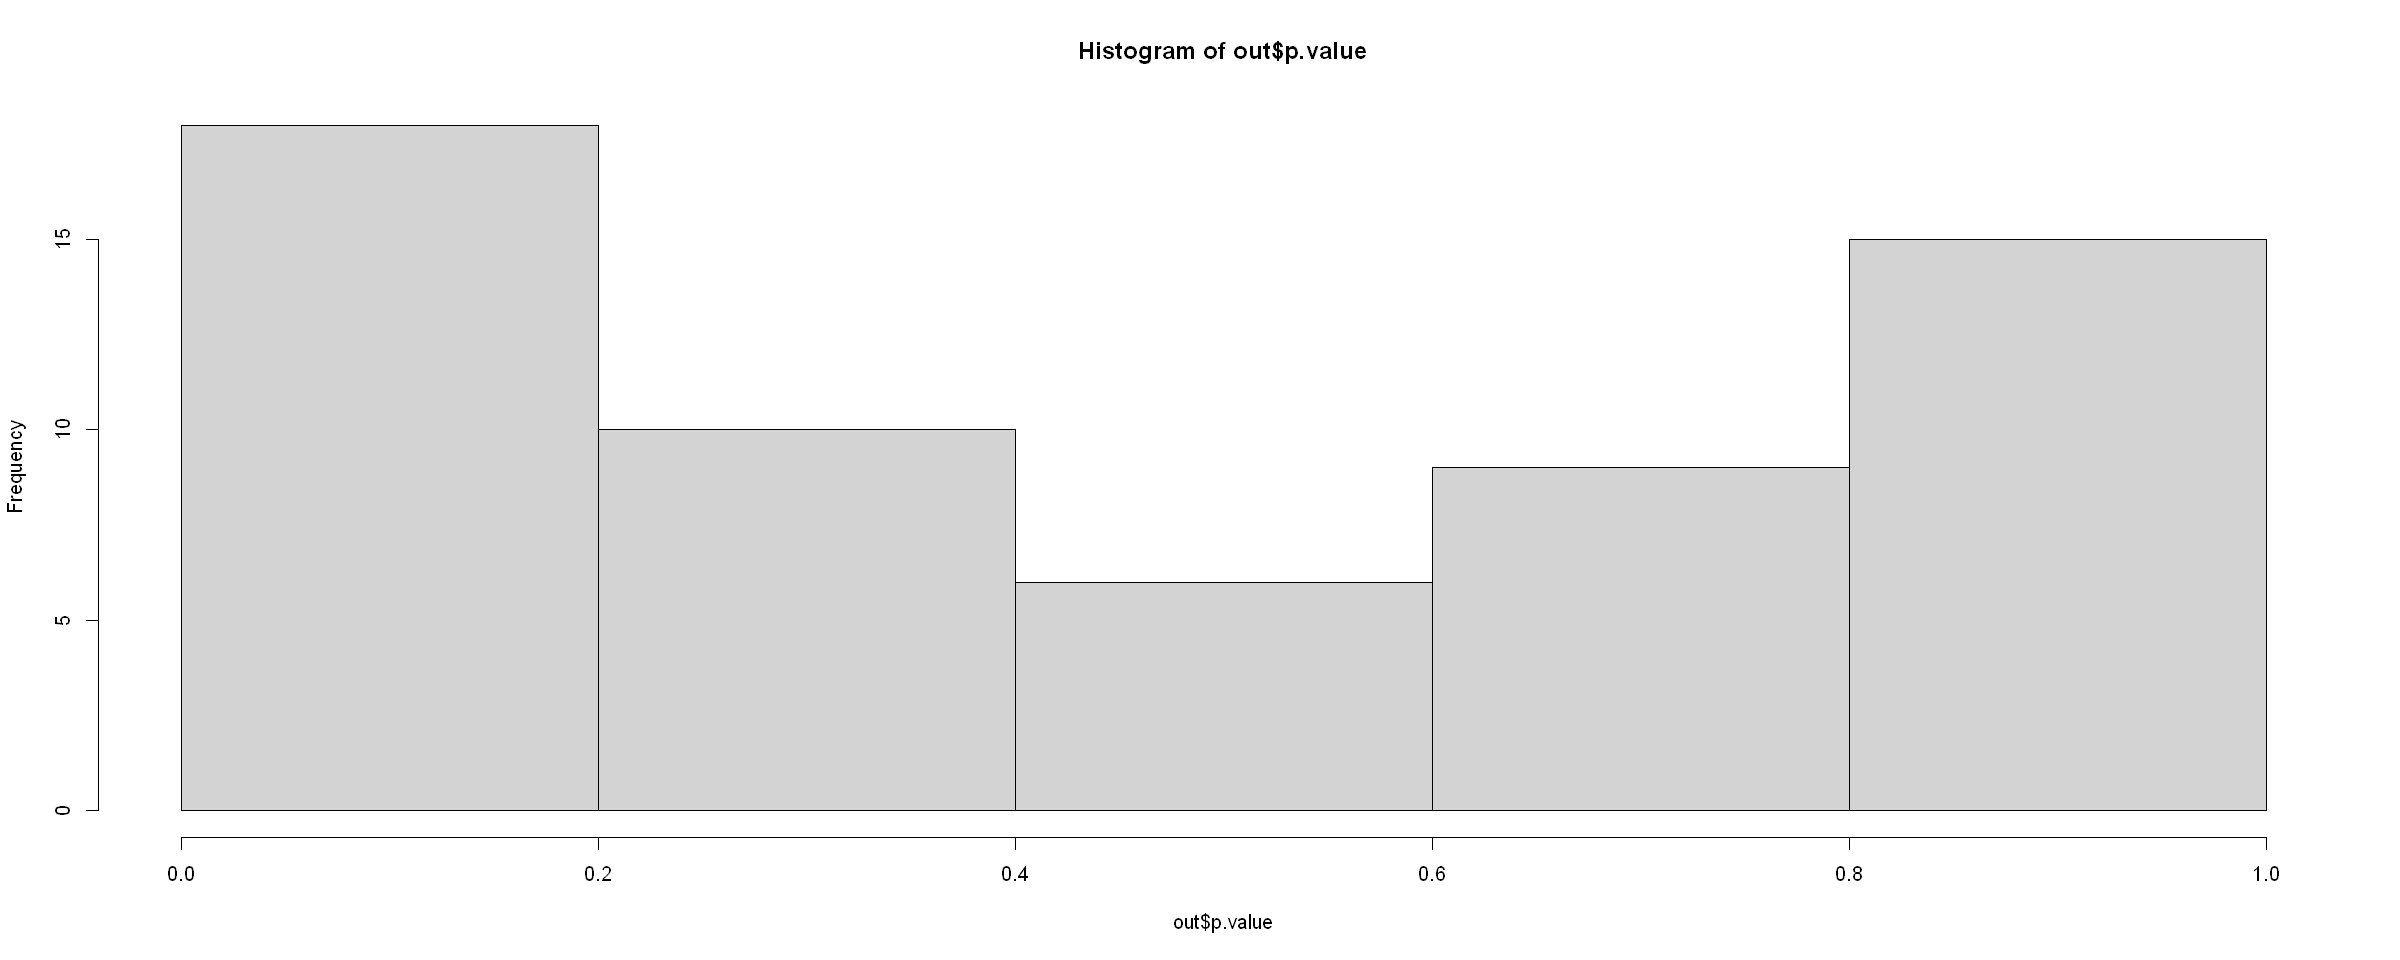

Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 10 rows containing missing values or values outside the scale range (`geom_text_repel()`)."
Warning message:
"ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


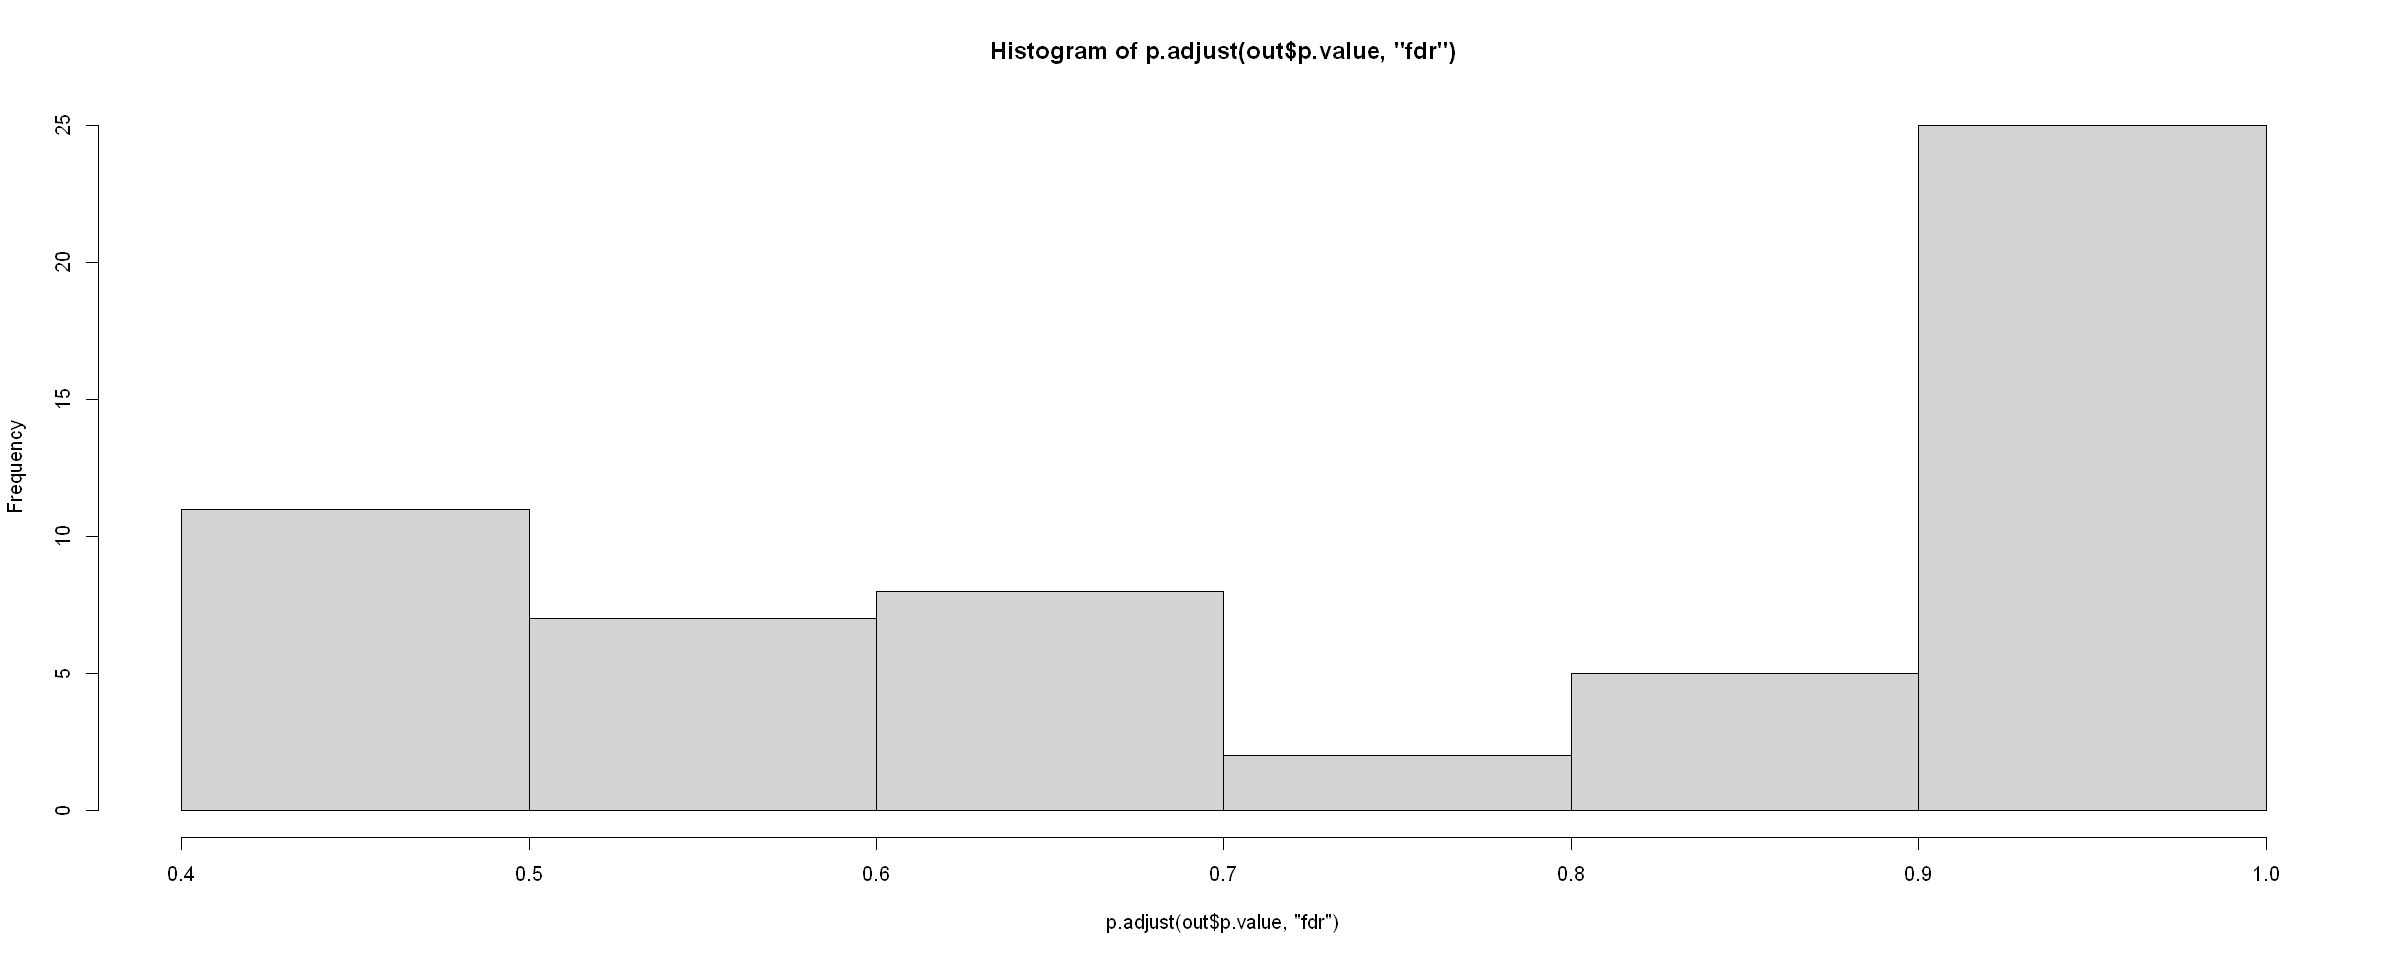

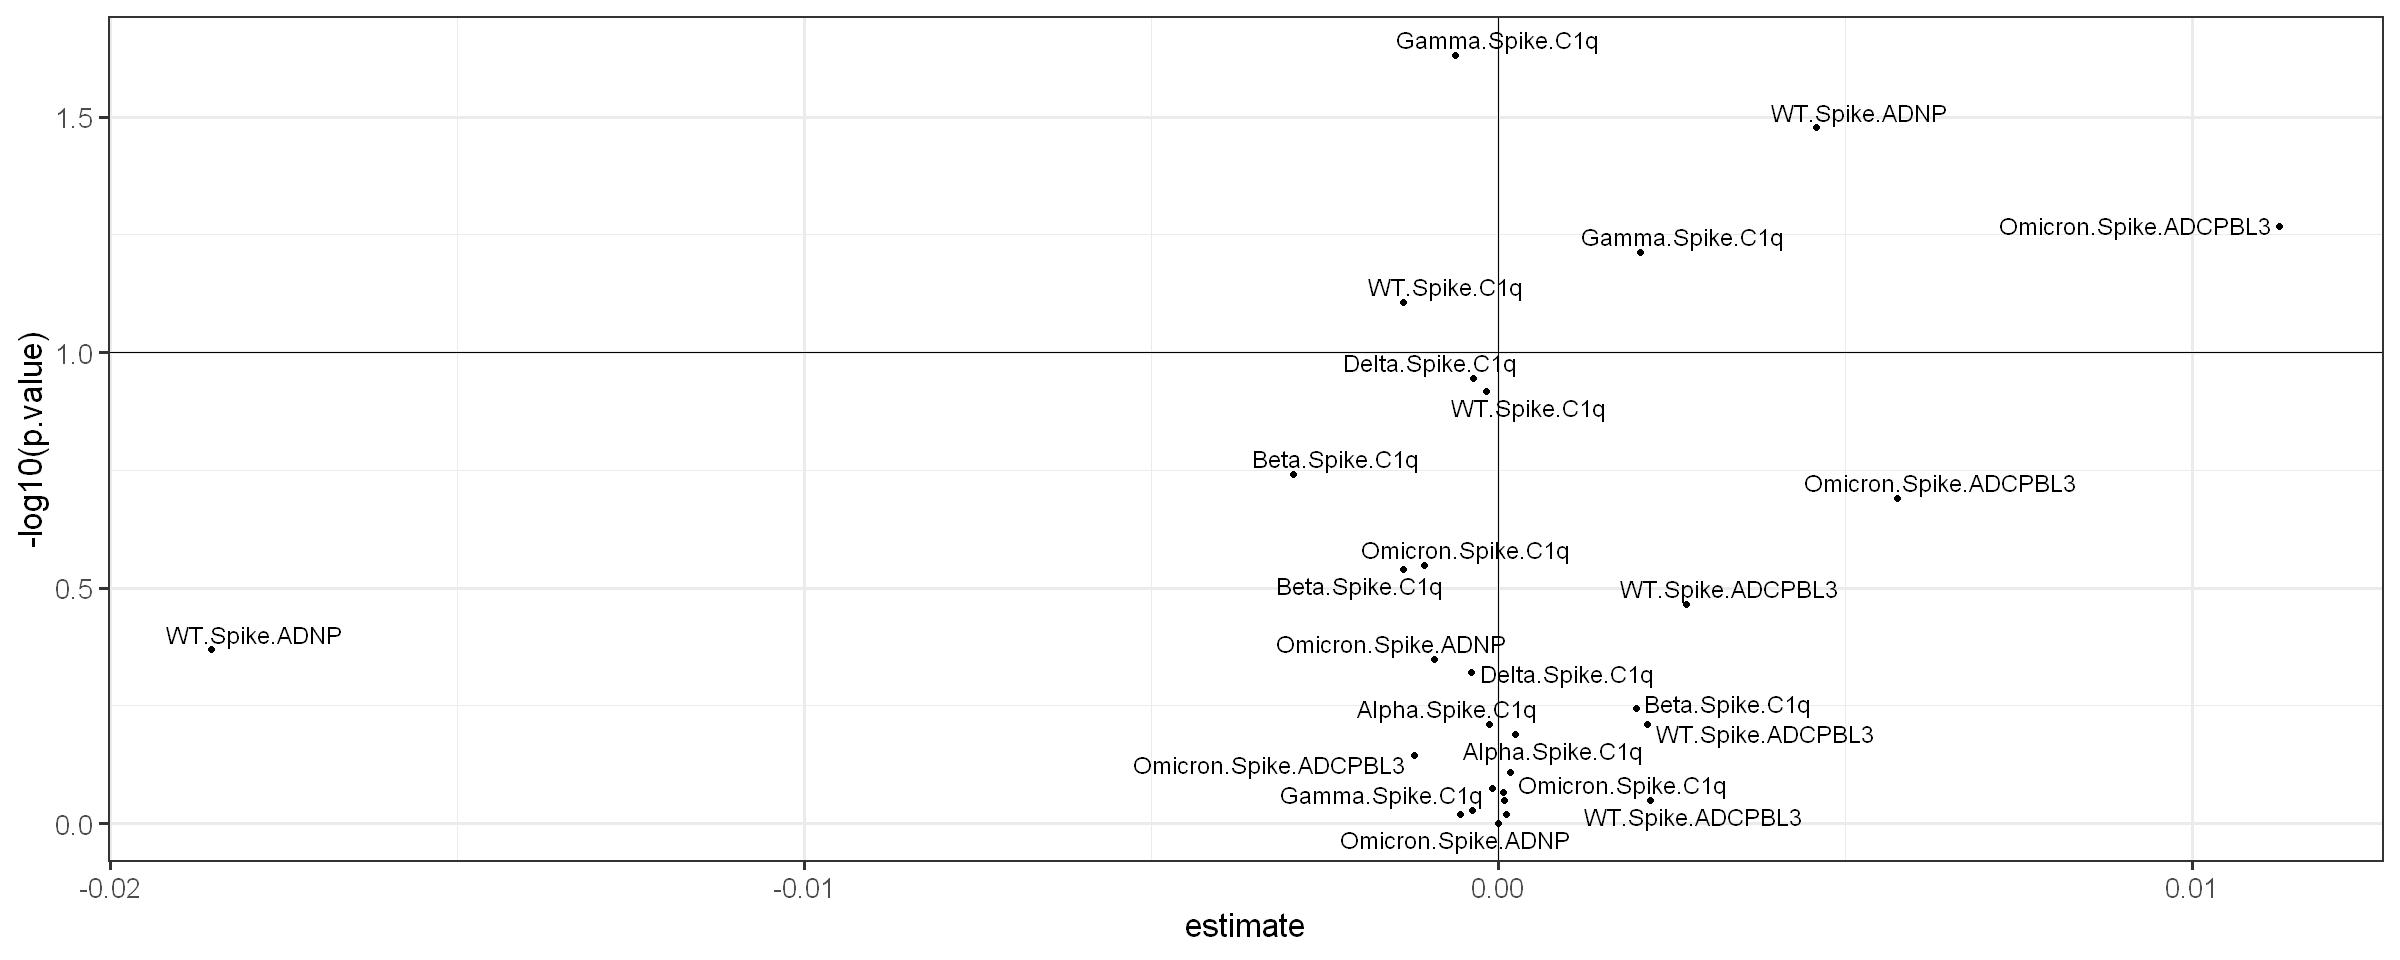

In [27]:
# with(tmp%>%
#      filter(vaccine2=='OutCoronaVac' & variable=='WT.Spike.IgG1') %>% unique() %>% na.omit(),
#      table(Lab.ID))

options(repr.plot.width=20, repr.plot.height=8)

out=list()

for(vari in grep('Spike',unique(tmp$variable),value=T)[1:10]){
    for(vaci in unique(tmp$vaccine2)){
        # print(vari)
        tmpi=tmp %>% 
            filter( vaccine2==vaci & variable==vari ) %>%
            arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
            droplevels()
        tab = table(tmpi$Lab.ID)
        tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2])

        tmpi$diff_minmax = rep(tmpi$value_minmax[tmpi$vaccine==vaci]-tmpi$value_minmax[tmpi$vaccine!=vaci],2)
        tmpi = tmpi %>% filter(!is.na(DoSD) & is.finite(diff_minmax))

        # ggplot(tmpi,aes(y=diff_minmax,x=DoSD))+geom_point()+stat_smooth(method='glm')
        try(out[[length(out)+1]] <- cbind(as.data.frame(broom::tidy(glm(diff_minmax~DoSD,data=tmpi))),vaccine2=vaci,variable=vari))
    }
}

out=do.call(rbind,out)

# no evidence that boosting is influenced by Infection-Vaccination interval (DoSD)
hist(out$p.value)
hist(p.adjust(out$p.value,'fdr'))
ggplot(out%>%filter(term=='DoSD'),
       aes(x=estimate,y=-log10(p.value),label=variable))+
            geom_point()+ggrepel::geom_text_repel(size=5)+
            geom_hline(yintercept = 1)+geom_vline(xintercept = 0)+
            theme_bw(base_size=20)

# Paired univariate

In [39]:
options(repr.plot.width=25, repr.plot.height=8)


tmp=data_exp %>% arrange(Lab.ID,DPFD) %>% 
    mutate(
        DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T)),
        DoFD = DPFD-DPTD,
        DoSD = DPFD-DPSD
    ) %>%
    filter(
        # !grepl('^EBOV|^HCMV|^Influenza',variable)
        DPFD>0
    ) %>%
    group_by(Lab.ID,
             vaccine,antigen,affinity,virus,
             variable,group) %>% 
        summarise(
            value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , value[ which.max(DPFD) ] ),  #  min(value,na.rm=T)),
            naive_97.5 = (unique(naive_97.5)),
            # value_minmax = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
            value_max = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , max(value,na.rm=T)),
            DoFD = unique(c(DoFD,NA))[1],
            DoSD = unique(c(DoSD,NA))[1]
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)], #[which.max(nchar(Vaccine))]
            vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))
        ) %>% 
    filter(     
           group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine) 
          ) %>% droplevels()

# head(
    tmp %>% filter(vaccine%in%c('OutCoronaVac') & variable=='WT.Spike.IgG1')
    # ) #%>% select(vaccine,group,Lab.ID,variable,DoFD,DoSD),n=20)

Warning message:
"There were 2277 warnings in `summarise()`.
The first warning was:
i In argument: `value_minmax = if_else(...)`.
i In group 278: `Lab.ID = "C100 2021 G4"`, `vaccine = "CoronaVac2+Pfizer"`, `antigen = "N"`, `affinity = "R3av"`,
  `virus = WT`, `variable = "WT.N.R3av"`, `group = "C"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
i Run `dplyr::last_dplyr_warnings()` to see the 2276 remaining warnings."
Warning message:
"Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
i Please use `reframe()` instead.
i When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame
  and adjust accordingly."
`summarise()` has grouped output by 'Lab.ID', 'vaccine', 'antigen', 'affinity', 'virus', 'variable', 'group'. You can
override using the `.groups` argument.


Lab.ID,vaccine,antigen,affinity,virus,variable,group,value_minmax,naive_97.5,value_max,DoFD,DoSD,vaccine2
<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
op1 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,40.090003,9.138638,40.090003,378,350,OutCoronaVac
op100 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,38.444139,9.138638,38.444139,155,127,OutCoronaVac
op100 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,38.444139,9.138638,38.444139,155,127,OutCoronaVac
op101 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,-Inf,9.138638,-Inf,253,225,OutCoronaVac
op104 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,48.879500,9.138638,48.879500,NA,151,OutCoronaVac
op104 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,48.879500,9.138638,48.879500,NA,151,OutCoronaVac
op105 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,28.632252,9.138638,28.632252,NA,103,OutCoronaVac
op105 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,28.632252,9.138638,28.632252,NA,103,OutCoronaVac
op105 2020 G4,OutCoronaVac,Spike,IgG1,WT,WT.Spike.IgG1,o,28.632252,9.138638,28.632252,NA,103,OutCoronaVac


In [29]:
# head(tmp %>% filter(vaccine%in%c('OutCoronaVac') & variable=='WT.Spike.IgG1')) #%>% select(vaccine,group,Lab.ID,variable,DoFD,DoSD),n=20)
stats = stats %>% mutate(
    p.adj = p.adjust(p.value,'fdr'),
    # p.adj.aov = p.adjust(aov_p,'fdr'),
    p.adj.t = p.adjust(t_p,'fdr'),
    '.y.'='value_minmax')
# head(stats)


In [30]:
# stats[stats$vi==vari,]
dim(stats)
dim(tmp)
dim(tmp2<-merge(y=stats[,colnames(stats)!='naive_97.5'],x=tmp,all.x=T,
          by.y=c('v2','vi','antigen','affinity','virus'),
          by.x=c('vaccine2','variable','antigen','affinity','virus')
          ))
head(tmp2)

[1] 544  24

[1] 53815    13

[1] 53815    31

,vaccine2,variable,antigen,affinity,virus,Lab.ID,vaccine,group,value_minmax,naive_97.5,...,alternative,md1,md2,diff,group1,group2,t_p,p.adj,p.adj.t,.y.
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<fct>,<chr>,<dbl>,<dbl>,...,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p3 2020 G4,HospCoronaVac,p,1.698255,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p7 2020 G4,Hosp,p,1.025498,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p6 2020 G4,Hosp,p,1.073810,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p6 2020 G4,Hosp,p,1.073810,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p6 2020 G4,Hosp,p,1.073810,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,HospCoronaVac,Alpha.RBD.C1q,RBD,C1q,Alpha,p6 2020 G4,Hosp,p,1.073810,1.26671,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [31]:
write.csv(unique(tmp2[c('vaccine','vaccine2','Lab.ID')]),'../data-final/DS2-USED-hybrid_boost_subjects.csv')

Warning message:
"Removed 9 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 9 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 7 rows containing missing values or values outside the scale range (`geom_line()`)."
Warning message:
"Removed 4 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 4 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message:
"Removed 3 rows containing missing values or values outside the scale range (`geom_line()`)."


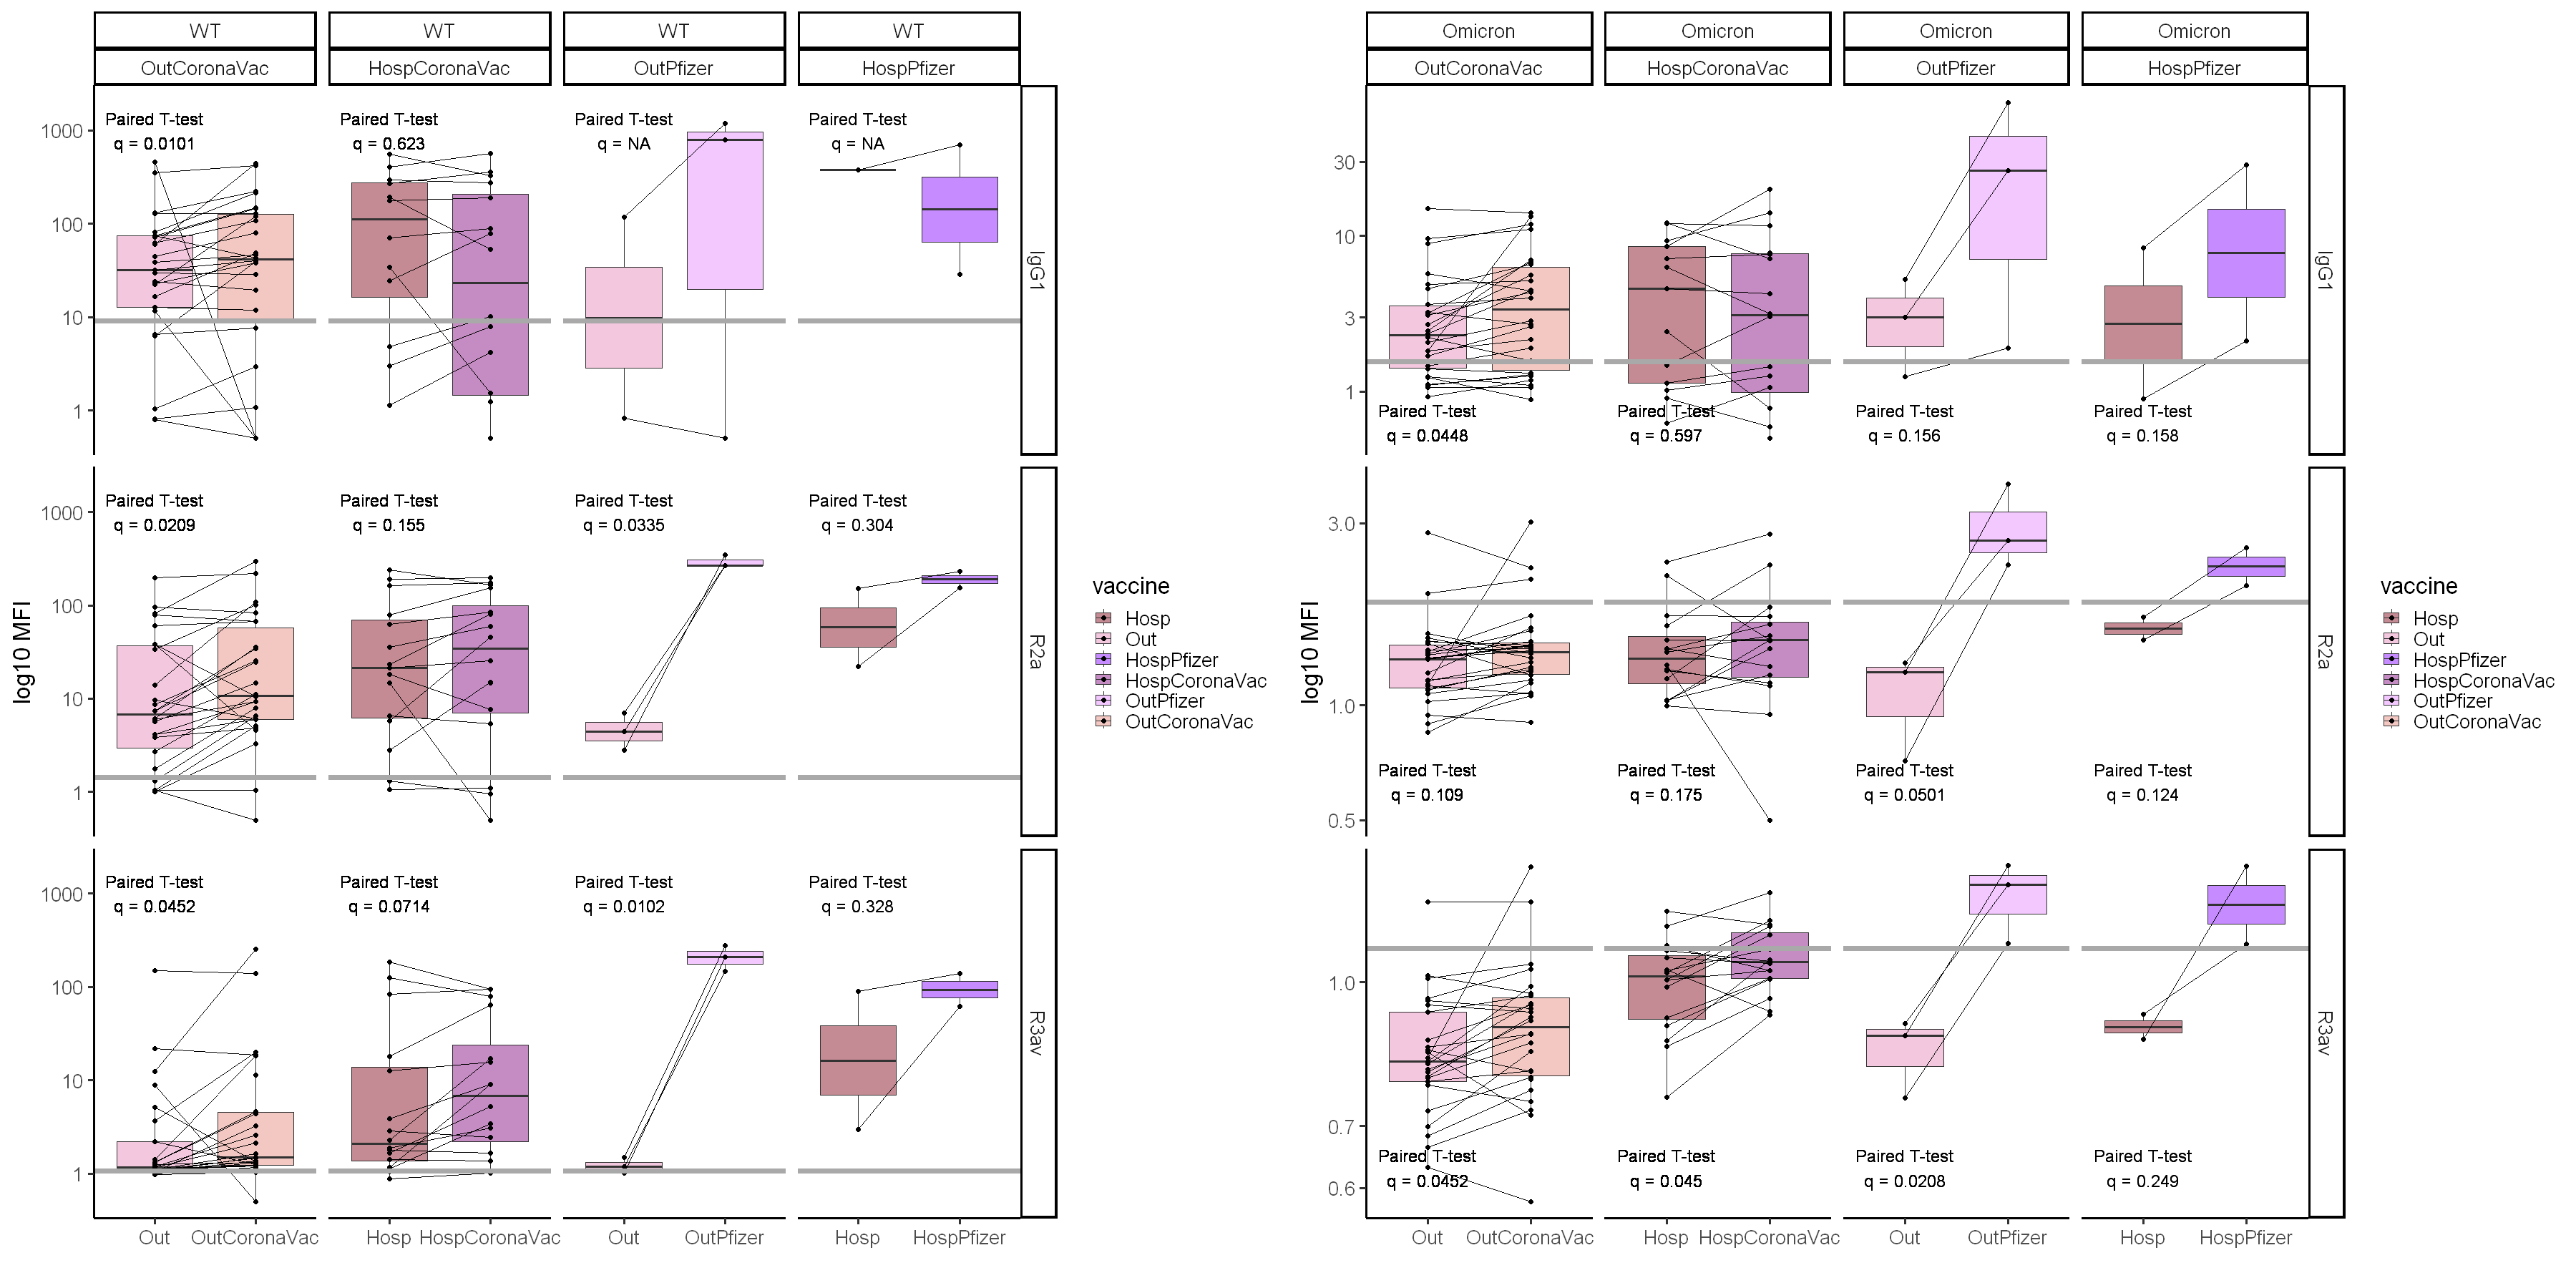

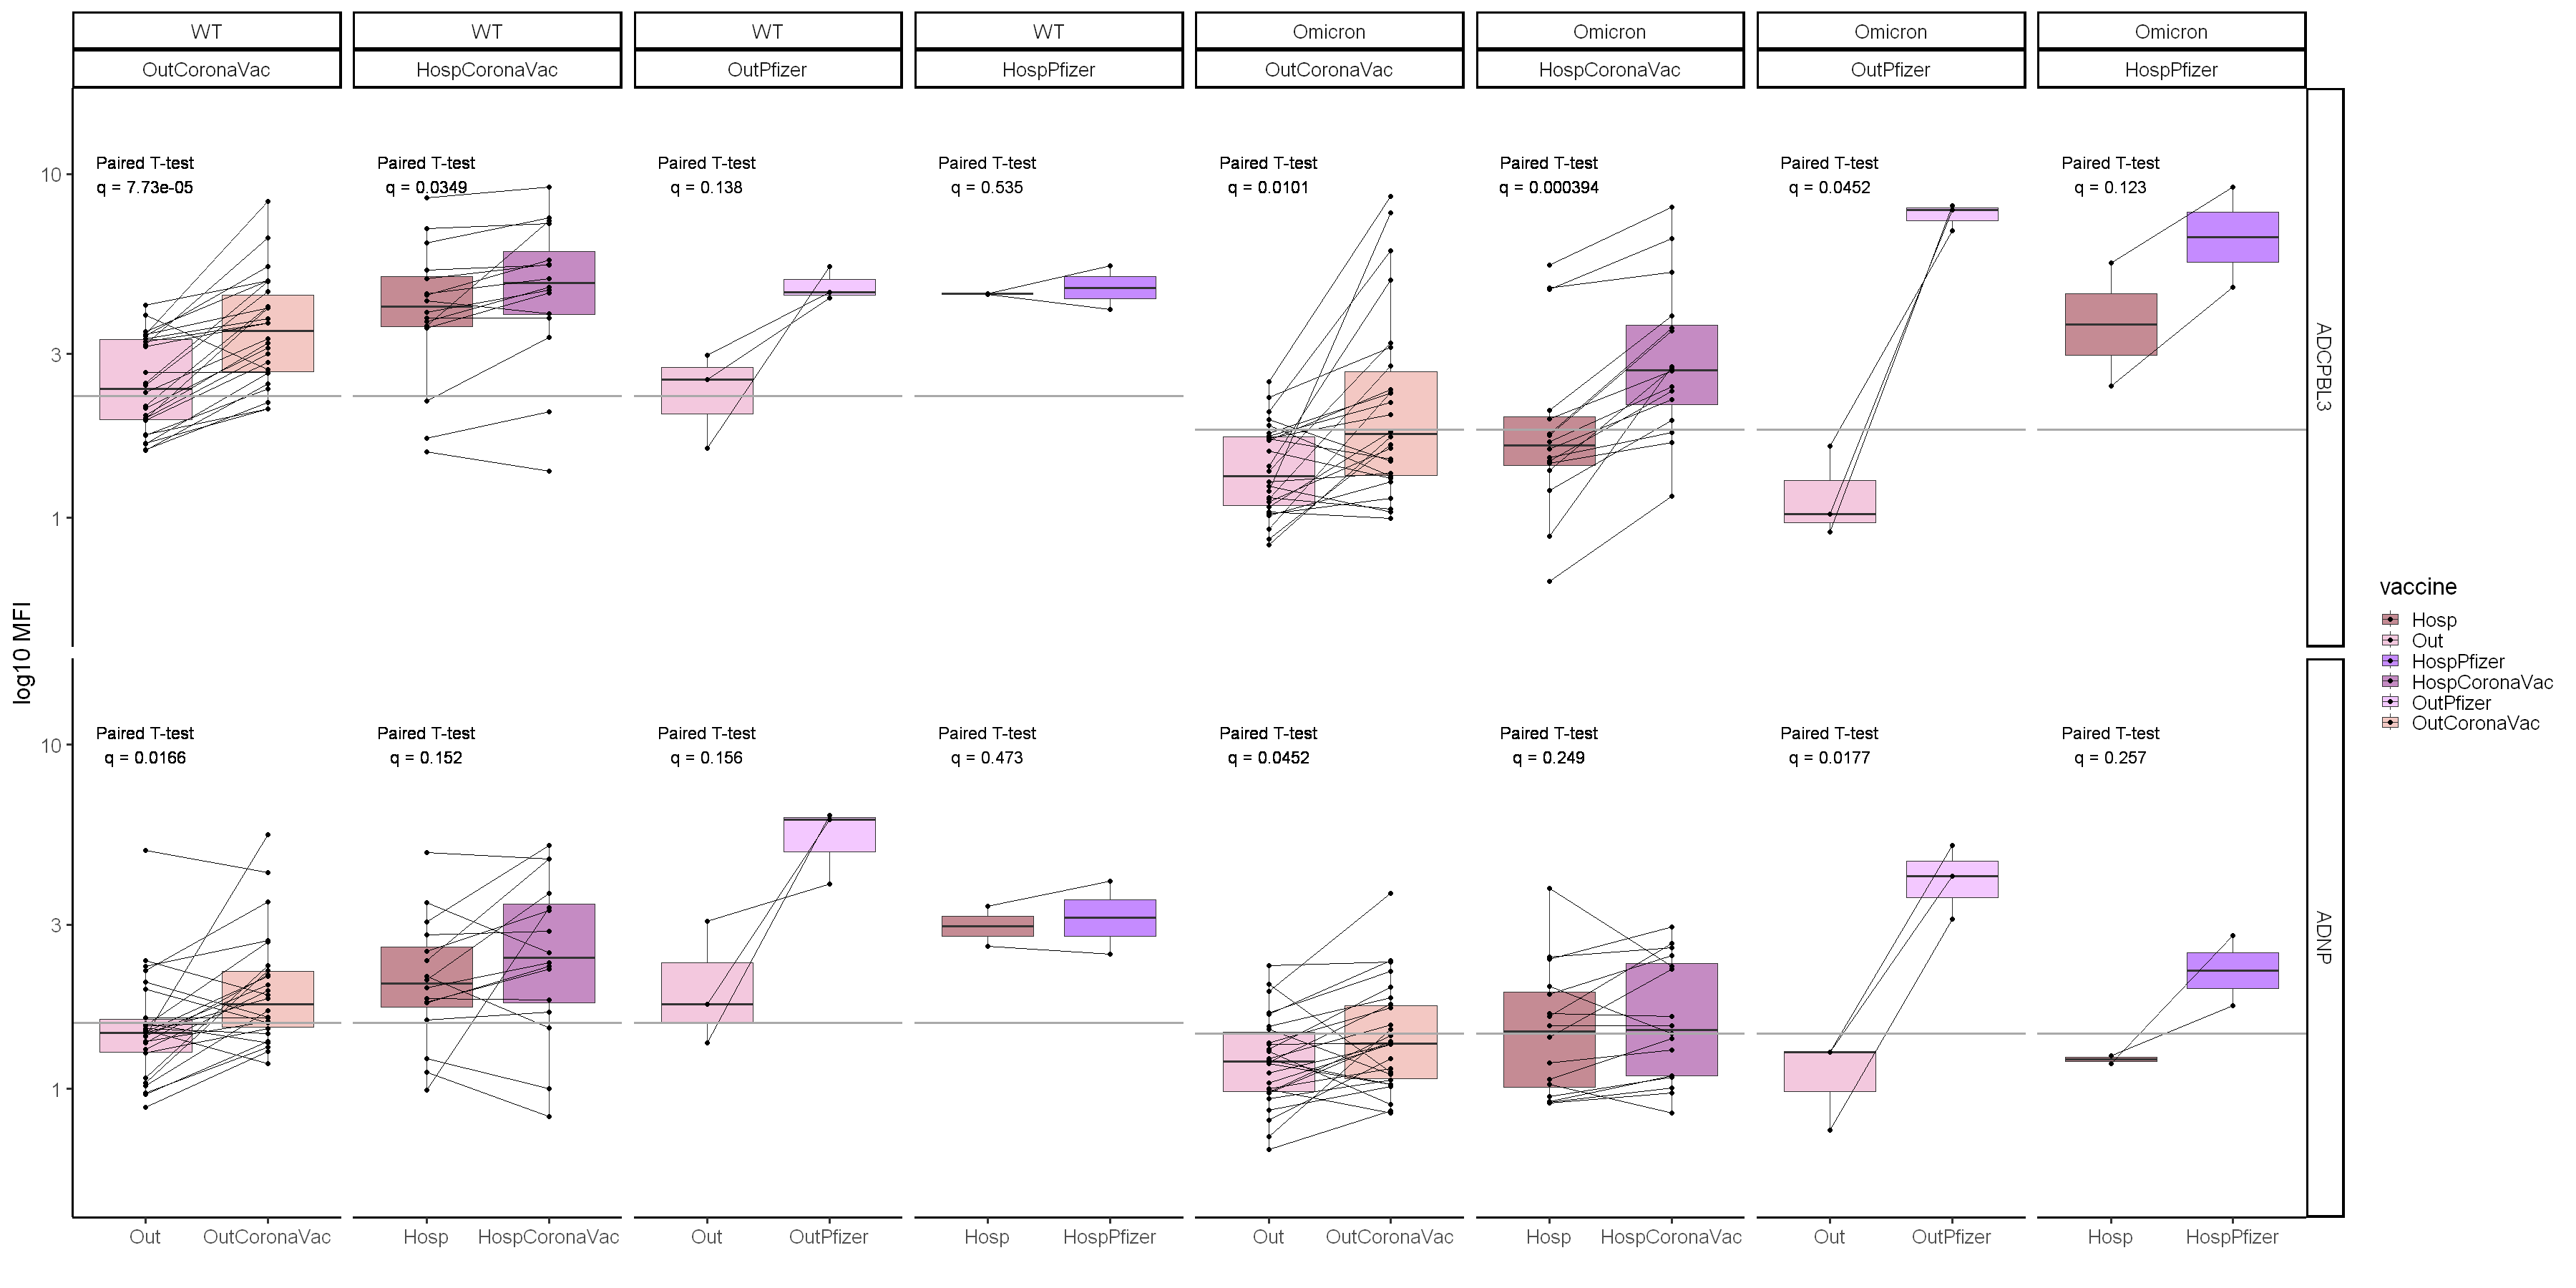

In [49]:
# vari = 'Omicron.Spike.IgG1'
# v2 = 'OutCoronaVac'

col = c('Pfizer'='#2933A3','CoronaVac'='#9DA3E7',
        'Hosp'='#8B182A','Out'='#E791BD',
           'HospCoronaVac'='#8B1888','OutCoronaVac'='#E79188',
           'HospPfizer'='#8B18FF','OutPfizer'='#E791FF')

tmpi=tmp2 %>% 
        # filter( variable==vari ) %>% # & vaccine2==v2 ) %>%
        filter(antigen=='Spike') %>%
        filter(variable%in% c(
            'WT.Spike.IgG1','Omicron.Spike.IgG1',
              # 'WT.Spike.IgG3','Omicron.Spike.IgG3',
              'WT.Spike.R2a','Omicron.Spike.R2a',
              # 'WT.Spike.R2b','Omicron.Spike.R2b',
              'WT.Spike.R3av','Omicron.Spike.R3av'
              # 'WT.Spike.R3b','Omicron.Spike.R3b',
              # 'WT.Spike.ADNP','Omicron.Spike.ADNP',
              # 'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3'
                             )) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        mutate(vaccine2=factor(as.character(vaccine2),levels = c('OutCoronaVac','HospCoronaVac','OutPfizer','HospPfizer'))) %>%
        droplevels()

g1= ggplot(tmpi %>% filter( virus=='WT') %>%mutate( value_minmax = if_else( value_minmax<0.5 , 0.5,value_minmax)),
          aes(x=vaccine,y=value_minmax,fill=vaccine))+
                geom_boxplot(outlier.shape = NA,alpha=0.5)+geom_text(aes(label=paste('Paired T-test\nq =',signif(p.adj,3))),y=3,x=1,size=5)+
                geom_point(color='black')+geom_line(aes(group=Lab.ID),color='black')+geom_hline(aes(yintercept = naive_97.5),size=2.2,color='darkgrey')+
                ylab('log10 MFI')+xlab('')+scale_y_log10(lim=c(0.5,2000))+scale_fill_manual(values = col[3:8])+
                theme_classic(base_size = 20)+facet_grid(affinity~virus+vaccine2,scale='free')
g2= ggplot(tmpi %>% filter( virus=='Omicron') %>%mutate( value_minmax = if_else( value_minmax<0.5 , 0.5,value_minmax)),
          aes(x=vaccine,y=value_minmax,fill=vaccine))+
                geom_boxplot(outlier.shape = NA,alpha=0.5)+geom_text(aes(label=paste('Paired T-test\nq =',signif(p.adj,3))),y=-0.2,x=1,size=5)+
                geom_point(color='black')+geom_line(aes(group=Lab.ID),color='black')+geom_hline(aes(yintercept = naive_97.5),size=2.2,color='darkgrey')+
                ylab('log10 MFI')+xlab('')+scale_y_log10()+scale_fill_manual(values = col[3:8])+
                theme_classic(base_size = 20)+facet_grid(affinity~virus+vaccine2,scale='free')
            

options(repr.plot.width=30, repr.plot.height=15)
cowplot::plot_grid(g1,g2,nrow=1)
ggsave(filename='../results/05_boost/minmax.luminex.pdf',width=30,height=15)
ggsave(filename='../results/fig4ab.pdf',width=30,height=15)


#########################

tmpi=tmp2 %>% 
        # filter( variable==vari ) %>% # & vaccine2==v2 ) %>%
        filter(antigen=='Spike') %>%
        filter(variable%in% c(
            # 'WT.Spike.IgG1','Omicron.Spike.IgG1',
              # 'WT.Spike.IgG3','Omicron.Spike.IgG3',
              # 'WT.Spike.R2a','Omicron.Spike.R2a',
              # 'WT.Spike.R2b','Omicron.Spike.R2b',
              # 'WT.Spike.R3av','Omicron.Spike.R3av',
              # 'WT.Spike.R3b','Omicron.Spike.R3b',
              'WT.Spike.ADNP','Omicron.Spike.ADNP',
              'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3'
                             )) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        mutate(vaccine2=factor(as.character(vaccine2),levels = c('OutCoronaVac','HospCoronaVac','OutPfizer','HospPfizer'))) %>%
        droplevels()



g2= ggplot(tmpi %>% mutate( value_minmax = if_else( value_minmax<0.5 , 0.5,value_minmax)),
           aes(x=vaccine,y=value_minmax,fill=vaccine))+
                geom_boxplot(outlier.shape = NA,alpha=0.5)+
                geom_text(aes(label=paste('Paired T-test\nq =',signif(p.adj,3))),y=1,x=1,size=5)+
                # geom_text(aes(label=paste0('Paired T-test q=',signif(p.adj,3),'\n','T-test q =',signif(p.adj.t,3))),y=1,x=1,size=5)+
                geom_point()+geom_line(aes(group=Lab.ID))+
                # stat_pvalue_manual(aes(group=v2),data=stats[stats$vi==vari,], label = "p.adj",y.position=1)+
                # ylim(mn,mx)+
scale_fill_manual(values = col[3:8])+
                geom_hline(aes(yintercept = naive_97.5),size=1,color='darkgrey')+
                ylab('log10 MFI')+xlab('')+
                # scale_y_log10()+
                scale_y_log10(lim=c(0.5,15))+
                theme_classic(base_size = 20)+#ggtitle(vari)+
                facet_grid(affinity~virus+vaccine2,scale='free')

options(repr.plot.width=30, repr.plot.height=15)
g2
ggsave(filename='../results/05_boost/minmax.functional.pdf',width=30,height=15)
ggsave(filename='../results/fig4cd.pdf',width=30,height=15)


Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 273 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 273 rows containing missing values or values outside the scale range (`geom_point()`)."
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message in transformation$transform(x):
"NaNs produced"
Warning message:
"Removed 273 rows containing non-finite outside the scale range (`stat_boxplot()`)."
Warning message:
"Removed 273 rows containing missing values or values outside the scale range (`geom_point()`)."


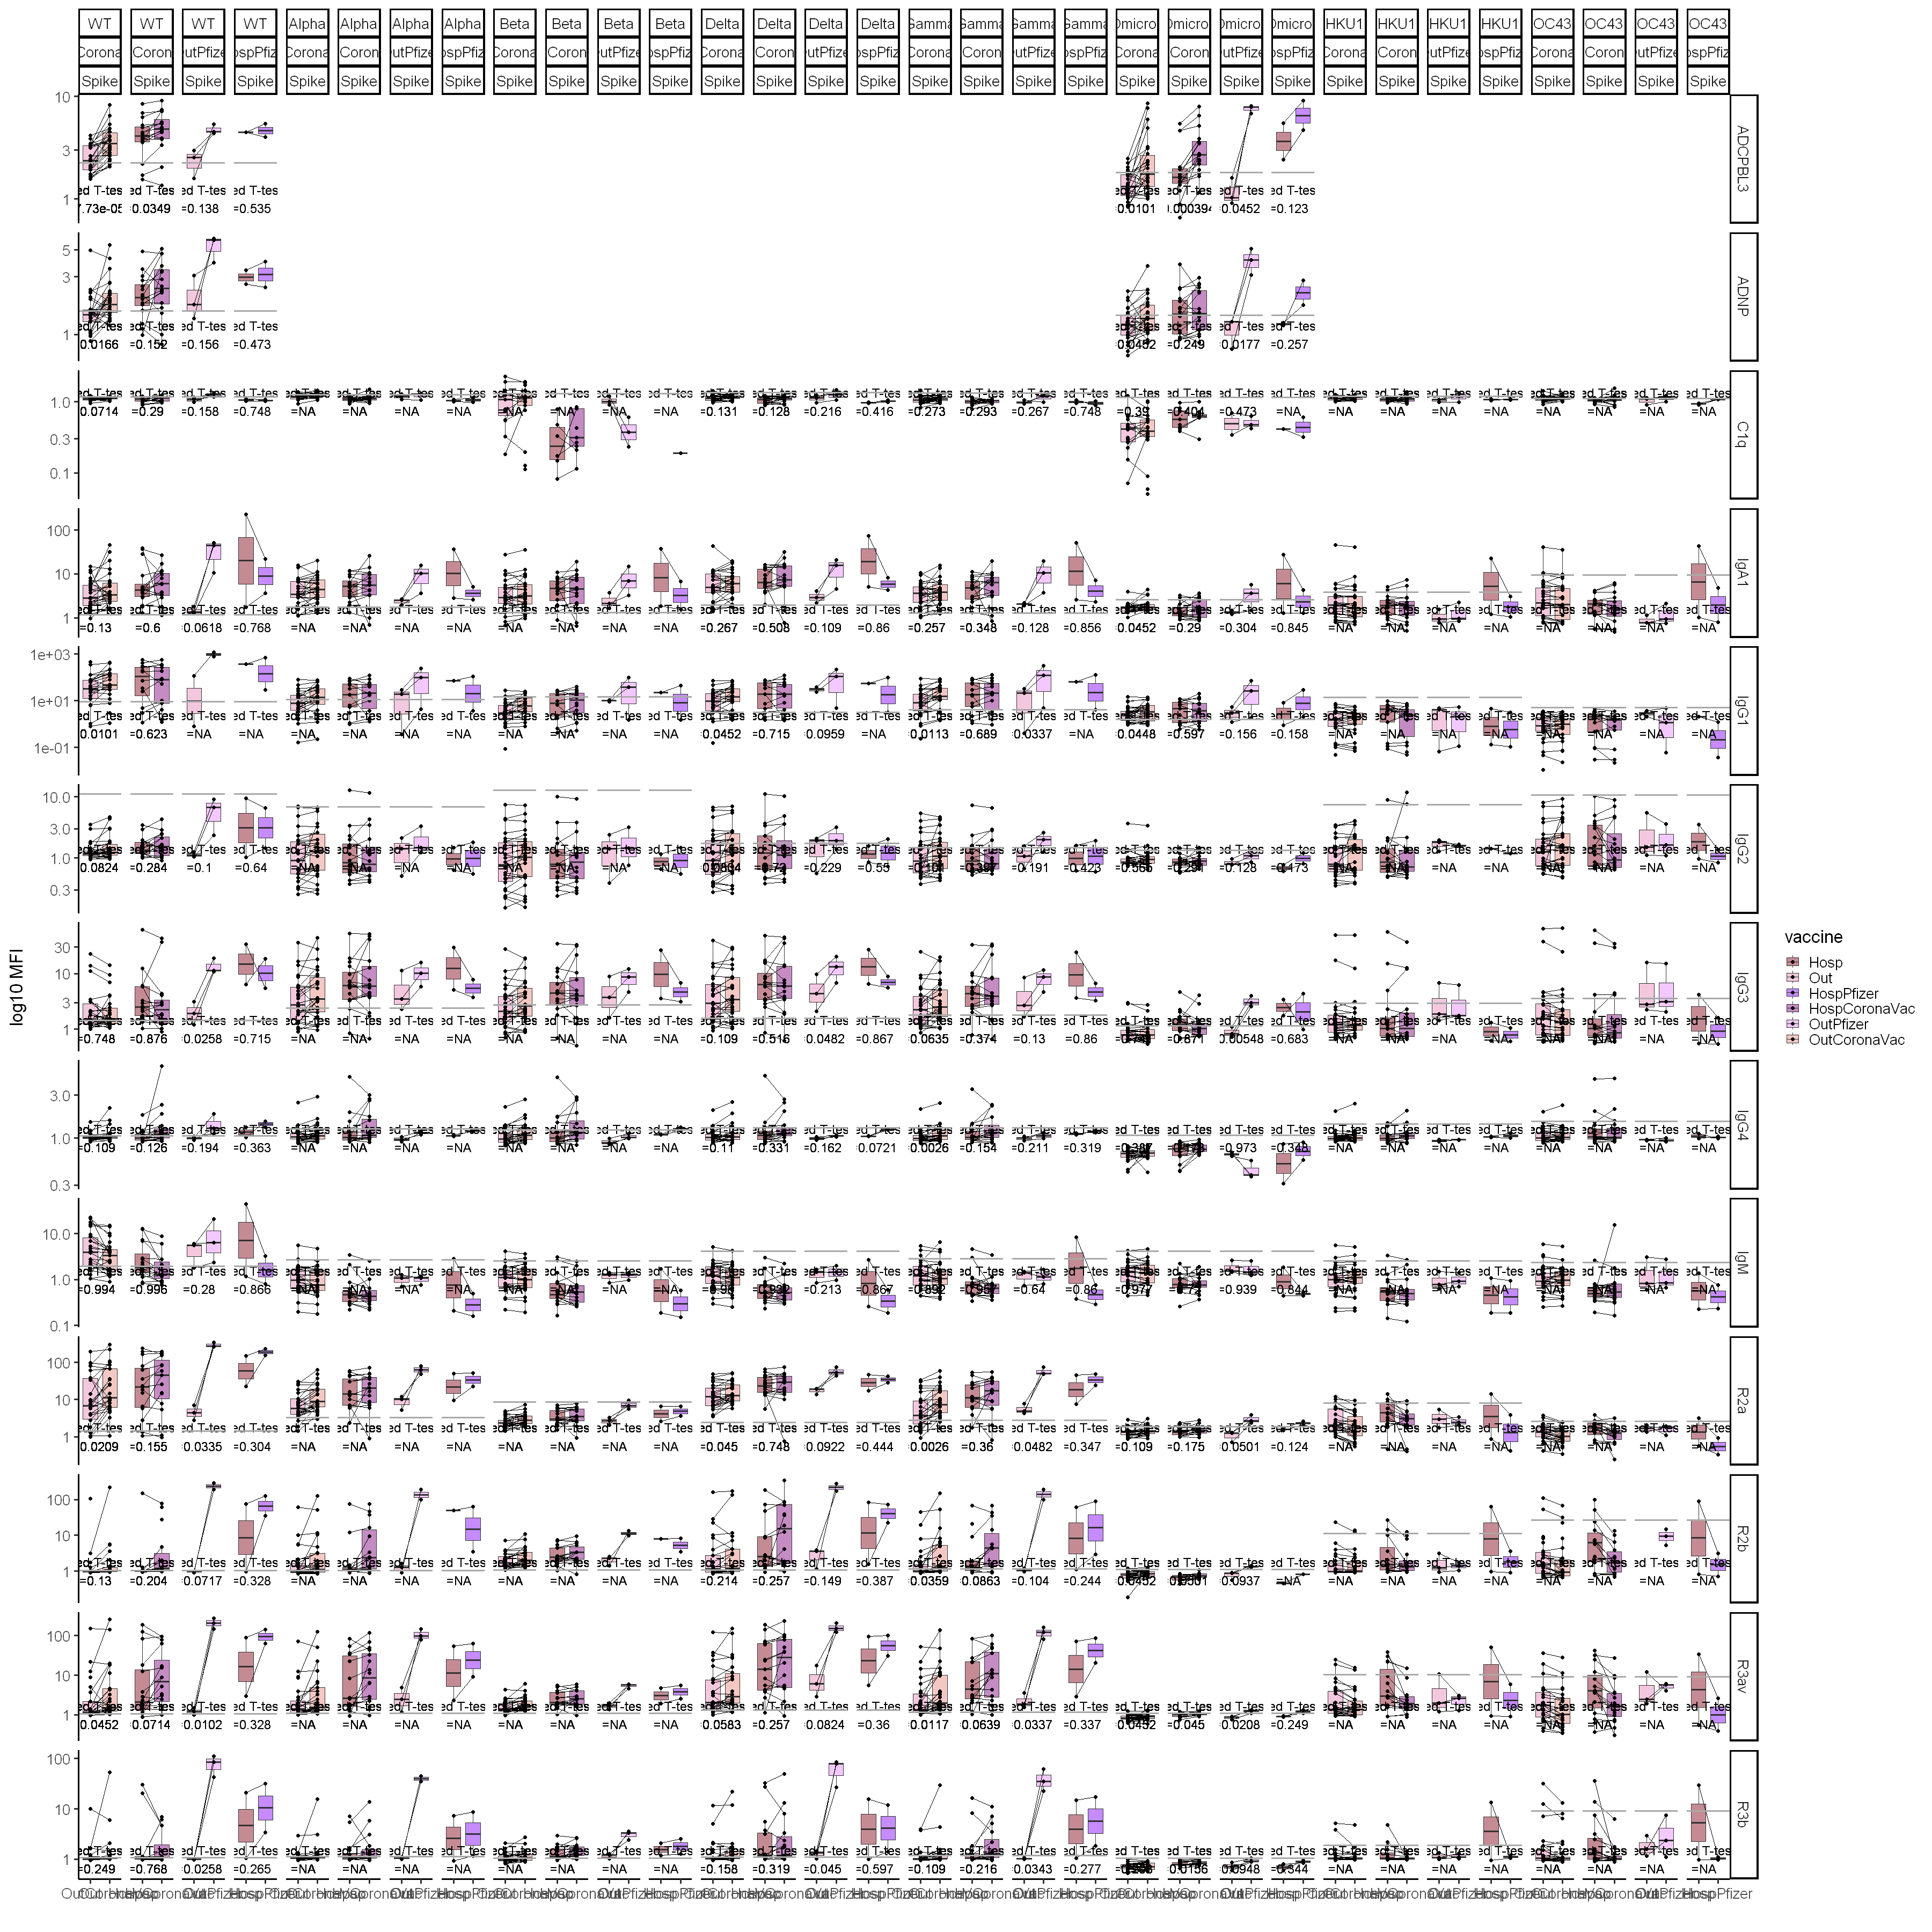

In [33]:
tmpi=tmp2 %>% 
        # filter( variable==vari ) %>% # & vaccine2==v2 ) %>%
        filter(antigen=='Spike') %>%
        # filter(variable%in% c(
        #     # 'WT.Spike.IgG1','Omicron.Spike.IgG1',
        #       # 'WT.Spike.IgG3','Omicron.Spike.IgG3',
        #       # 'WT.Spike.R2a','Omicron.Spike.R2a',
        #       # 'WT.Spike.R2b','Omicron.Spike.R2b',
        #       # 'WT.Spike.R3av','Omicron.Spike.R3av',
        #       # 'WT.Spike.R3b','Omicron.Spike.R3b',
        #       'WT.Spike.ADNP','Omicron.Spike.ADNP',
        #       'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3'
        #                      )) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        mutate(vaccine2=factor(as.character(vaccine2),levels = c('OutCoronaVac','HospCoronaVac','OutPfizer','HospPfizer'))) %>%
        droplevels()



g2= ggplot(tmpi,aes(x=vaccine,y=value_minmax,fill=vaccine))+
                geom_boxplot(outlier.shape = NA,alpha=0.5)+
                geom_text(aes(label=paste0('Paired T-test\nq =',signif(p.adj,3))),y=0,x=1,size=5)+
                # geom_text(aes(label=paste0('Paired T-test q=',signif(p.adj,3),'\n','T-test q =',signif(p.adj.t,3))),y=1,x=1,size=5)+
                geom_point()+geom_line(aes(group=Lab.ID))+
                # stat_pvalue_manual(aes(group=v2),data=stats[stats$vi==vari,], label = "p.adj",y.position=1)+
                # ylim(mn,mx)+
scale_fill_manual(values = col[3:8])+
                geom_hline(aes(yintercept = naive_97.5),size=1,color='darkgrey')+
                ylab('log10 MFI')+xlab('')+
                scale_y_log10()+
                theme_classic(base_size = 20)+#ggtitle(vari)+
                facet_grid(affinity~virus+vaccine2+antigen,scale='free')

options(repr.plot.width=30, repr.plot.height=30)
g2
ggsave(filename='../results/05_boost/minmax.all.pdf',width=45,height=45)


In [34]:
stop()

ERROR: Error in eval(expr, envir, enclos): 


In [ ]:
# vari = 'Omicron.Spike.IgG1'
# v2 = 'OutCoronaVac'

tmpi=tmp2 %>% 
        # filter( variable==vari ) %>% # & vaccine2==v2 ) %>%
        filter(antigen=='Spike') %>%
        filter(variable%in% c('WT.Spike.IgG1','Omicron.Spike.IgG1',
              # 'WT.Spike.IgG3','Omicron.Spike.IgG3',
              'WT.Spike.R2a','Omicron.Spike.R2a',
              'WT.Spike.R2b','Omicron.Spike.R2b',
              'WT.Spike.R3av','Omicron.Spike.R3av',
              'WT.Spike.R3b','Omicron.Spike.R3b',
              'WT.Spike.ADNP','Omicron.Spike.ADNP',
              'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3')) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        mutate(vaccine2=factor(as.character(vaccine2),levels = c('OutCoronaVac','HospCoronaVac','OutPfizer','HospPfizer'))) %>%
        droplevels()
    # tab = table(tmpi$Lab.ID)
    # tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2]) %>%
    #             mutate(value_minmax_log=log10(value_minmax))
    
    # top=max(tmpi$value_minmax_log,na.rm=T)
        
    # ggpaired(tmpi,x='vaccine',y='value_minmax_log')+
                # stat_compare_means(method = 'anova',size=6,label.y = mx-mx*.04)+
                # stat_compare_means(method = 't.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y = mx-mx*.1)+
g= ggplot(tmpi,aes(x=vaccine,y=value_minmax))+
                geom_boxplot(outlier.shape = NA)+
                geom_text(aes(label=paste('Paired T-test\nq=',signif(p.adj,3))),y=2,x=1)+
                geom_point()+geom_line(aes(group=Lab.ID))+
                # stat_pvalue_manual(aes(group=v2),data=stats[stats$vi==vari,], label = "p.adj",y.position=1)+
                # ylim(mn,mx)+
                geom_hline(aes(yintercept = naive_97.5),size=2,color='darkgrey')+
                ylab('log10 MFI')+xlab('')+
                scale_y_log10()+
                theme_classic(base_size = 20)+ggtitle(vari)+
                facet_grid(affinity~virus+vaccine2,scale='free')

options(repr.plot.width=30, repr.plot.height=25)
g


#     ggpaired(tmpi,x='vaccine',y='value_minmax_log')+
#                 stat_compare_means(method = 'anova',size=6,label.y = mx-mx*.04)+
#                 stat_compare_means(method = 't.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y = mx-mx*.1)+
#                 # stat_compare_means(method = 't.test', paired=T,size=6,label.y = top+top*.05)+
#                 # stat_compare_means(method = 'wilcox.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y=top+top*.05)+
# #                scale_y_log10()+
#                 ylim(mn,mx)+
#                 geom_hline(yintercept =unique(log10(tmpi$naive_97.5)),size=2,color='darkgrey')+
#                 # ylim( min( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T),
#                 #      max( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T))+
#                 ylab('log10 MFI')+xlab('')+
#                 theme_classic(base_size = 20)+ggtitle(vari)+
#                 facet_grid(~vaccine2)

In [ ]:

# # out_minmax=list()
# for(vari in unique(grep('S2',tmp$variable,value=T))){
#     # vari=gsub('Spike','S2',vari)
#     # print(vari)
#     g=gridExtra::grid.arrange(grobs=lapply(unique(tmp$vaccine2),function(v2){
    
#     tmpi=tmp %>% 
#         filter( vaccine2==v2 & variable==vari ) %>%
#         arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
#         droplevels()
#     tab = table(tmpi$Lab.ID)
#     tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2])
        
#     ggpaired(tmpi,x='vaccine',y='value_minmax')+
#                 stat_compare_means(paired=T,method.args = list('alternative'='greater'),size=6)+
#                 scale_y_log10()+ylab('MFI')+xlab('')+
#                 theme_classic(base_size = 20)+ggtitle(vari)
# }),nrow=1)
# # out_minmax[[vari]] = g
#     # try(print(g))
# }

In [ ]:



############# minmax

out_minmax=list()
for(vari in c('WT.Spike.IgG1','Omicron.Spike.IgG1',
              'WT.Spike.IgG3','Omicron.Spike.IgG3',
              'WT.Spike.R2a','Omicron.Spike.R2a',
              'WT.Spike.R2b','Omicron.Spike.R2b',
              'WT.Spike.R3av','Omicron.Spike.R3av',
              'WT.Spike.R3b','Omicron.Spike.R3b',
              'WT.Spike.ADNP','Omicron.Spike.ADNP',
              'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3')){
    
    # mx= max(log10(tmp$value_minmax)[tmp$variable==vari],na.rm=T)
    # mn= min(log10(tmp$value_minmax)[tmp$variable==vari],na.rm=T)
    mx= max(log10(tmp$value_minmax)[tmp$variable==gsub('Omicron','WT',vari)],na.rm=T)
    mn= min(log10(tmp$value_minmax)[tmp$variable==gsub('Omicron','WT',vari)],na.rm=T)
    
    g=gridExtra::grid.arrange(grobs=lapply(unique(tmp$vaccine2),function(v2){
    
    tmpi=tmp %>% 
        filter( vaccine2==v2 & variable==vari ) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        droplevels()
    tab = table(tmpi$Lab.ID)
    tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2]) %>%
                mutate(value_minmax_log=log10(value_minmax))
    
    top=max(tmpi$value_minmax_log,na.rm=T)
        
        # print(log10(tmpi$naive_97.5))
        
        # print( unique(tmp$vaccine[grepl(substr(v2,1,3), tmp$vaccine)]))
        
    ggpaired(tmpi,x='vaccine',y='value_minmax_log')+
                stat_compare_means(method = 'anova',size=6,label.y = mx-mx*.04)+
                stat_compare_means(method = 't.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y = mx-mx*.1)+
                # stat_compare_means(method = 't.test', paired=T,size=6,label.y = top+top*.05)+
                # stat_compare_means(method = 'wilcox.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y=top+top*.05)+
#                scale_y_log10()+
                ylim(mn,mx)+
                geom_hline(yintercept =unique(log10(tmpi$naive_97.5)),size=2,color='darkgrey')+
                # ylim( min( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T),
                #      max( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T))+
                ylab('log10 MFI')+xlab('')+
                theme_classic(base_size = 20)+ggtitle(vari)
}),nrow=1)
out_minmax[[vari]] = g
    # stop()
}

options(repr.plot.width=30, repr.plot.height=50)

g1=gridExtra::grid.arrange(grobs=out_minmax,ncol=2)
g1
ggsave(g1,filename='../results/05_boost/minmax.pdf',height=49,width=35)




In [ ]:
# ###################################################


# options(repr.plot.width=15, repr.plot.height=8)


# ############# minmax

# vari='Omicron.Spike.R2a'

#     mx= max(log10(tmp$value_minmax)[tmp$variable==gsub('Omicron','WT',vari)],na.rm=T)
#     mn= min(log10(tmp$value_minmax)[tmp$variable==gsub('Omicron','WT',vari)],na.rm=T)

# v2 = unique(tmp$vaccine2)[1]
    
#     # gridExtra::grid.arrange(grobs=lapply(unique(tmp$vaccine2),function(v2){
    
#     tmpi=tmp %>% 
#         filter( vaccine2==v2 & variable==vari ) %>%
#         arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
#         droplevels()
#     tab = table(tmpi$Lab.ID)
#     tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2]) %>%
#                 mutate(value_minmax_log=log10(value_minmax))
    
#     top=max(tmpi$value_minmax_log,na.rm=T)
        
#         # print(log10(tmpi$naive_97.5))
        
#         # print( unique(tmp$vaccine[grepl(substr(v2,1,3), tmp$vaccine)]))
        
#     ggpaired(tmpi,x='vaccine',y='value_minmax_log')+
#                 stat_compare_means(method = 'anova',size=6,label.y = mx-mx*.04)+
#                 stat_compare_means(method = 't.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y = mx-mx*.1)+
#                 # stat_compare_means(method = 't.test', paired=T,size=6,label.y = top+top*.05)+
#                 # stat_compare_means(method = 'wilcox.test', paired=T,method.args = list('alternative'='greater'),size=6,label.y=top+top*.05)+
# #                scale_y_log10()+
#                 ylim(mn,mx)+
#                 geom_hline(yintercept =unique(log10(tmpi$naive_97.5)),size=2,color='darkgrey')+
#                 # ylim( min( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T),
#                 #      max( log10(tmp$value_minmax [ grepl(substr(v2,1,3), tmp$vaccine)]),na.rm=T))+
#                 ylab('log10 MFI')+xlab('')+
#                 theme_classic(base_size = 20)+ggtitle(vari)

# # }),nrow=1)

# # out_minmax[[vari]] = g
# #     # stop()
# # }

# # options(repr.plot.width=30, repr.plot.height=50)

# # g1=gridExtra::grid.arrange(grobs=out_minmax,ncol=2)
# # g1
# # ggsave(g1,filename='../results/05_boost/minmax.pdf',height=49,width=35)




# ####################################################

In [ ]:
############# max

outl_max=list()
for(vari in c('WT.Spike.IgG1','Omicron.Spike.IgG1',
              'WT.Spike.IgG3','Omicron.Spike.IgG3',
              'WT.Spike.R2a','Omicron.Spike.R2a',
              'WT.Spike.R2b','Omicron.Spike.R2b',
              'WT.Spike.R3av','Omicron.Spike.R3av',
              'WT.Spike.R3b','Omicron.Spike.R3b',
              'WT.Spike.ADNP','Omicron.Spike.ADNP',
              'WT.Spike.ADCPBL3','Omicron.Spike.ADCPBL3')){
    g=gridExtra::grid.arrange(grobs=lapply(unique(tmp$vaccine2),function(v2){
    
    tmpi=tmp %>% 
        filter( vaccine2==v2 & variable==vari ) %>%
        arrange(vaccine,Lab.ID) %>% unique() %>% #na.omit() %>%
        droplevels()
    tab = table(tmpi$Lab.ID)
    tmpi = tmpi %>% filter(Lab.ID %in% names(tab)[tab==2])
        
    ggpaired(tmpi,x='vaccine',y='value_max')+
                stat_compare_means(paired=T,method.args = list('alternative'='greater'),size=6)+
                scale_y_log10()+ylab('MFI')+xlab('')+
                theme_classic(base_size = 20)+ggtitle(vari)
}),nrow=1)
outl_max[[vari]] = g
    # try(print(g))
}

In [ ]:
options(repr.plot.width=30, repr.plot.height=50)

g1=gridExtra::grid.arrange(grobs=out_minmax,ncol=2)
g1
ggsave(g1,filename='../results/05_boost/minmax.pdf',height=49,width=30)

options(repr.plot.width=30, repr.plot.height=50)

g2=gridExtra::grid.arrange(grobs=outl_max,ncol=2)
g2
ggsave(g2,filename='../results/05_boost/max.pdf',height=49,width=30)

In [ ]:
stop()

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)

head(data_i)
data_i %>% arrange(Lab.ID,DPFD) %>% 
    mutate(
                DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T))
    ) %>%
    filter(
        DPFI>30
    ) %>%
    group_by(Lab.ID,
             vaccine,
             variable,group) %>% 
        summarise(
            value = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)], #[which.max(nchar(Vaccine))]
            vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))
        ) %>% 
    filter(variable=='Omicron.Spike.IgG1' & group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine) 
          ) %>% droplevels() %>%
        ggplot(aes(x=vaccine,y=value,fill=vaccine))+
            geom_violin(draw_quantiles = c(.25,.5,.75))+
            geom_point()+
            geom_line(aes(group=Lab.ID))+
            theme_bw(base_size=20)+
            stat_compare_means(aes(id='Lab.ID'),paired=T)+
            # theme(legend.position = 'none')+
            scale_y_log10()+facet_wrap(~vaccine2,scale='free_x')

In [ ]:
options(repr.plot.width=20, repr.plot.height=8)

head(data_i)
data_i %>% arrange(Lab.ID,DPFD) %>% 
    group_by(Lab.ID,
             vaccine,
             variable,group) %>% 
        summarise(
            value = max(value,na.rm=T)
            # value = if_else( grepl('Pfizer$|CoronaVac$',vaccine), max(value,na.rm=T) , min(value,na.rm=T)),
        )%>% ungroup() %>%
    group_by( Lab.ID,
             # vaccine,
             variable,group
    ) %>%
        mutate(
            vaccine2 = vaccine[length(vaccine)] #[which.max(nchar(Vaccine))]
        ) %>%
    mutate(vaccine=factor(as.character(vaccine),levels = c('Pfizer','CoronaVac','Hosp','Out','HospPfizer','HospCoronaVac','OutPfizer','OutCoronaVac'))) %>%
    filter(variable=='WT.Spike.IgG1' & group%in%c('C','o','p')[1:3] & grepl('Pfizer$|CoronaVac$',vaccine2) & grepl('^Hosp|^Out',vaccine2) &
           !vaccine%in%c('Naive','CoronaVac2+Pfizer') & !vaccine2%in%c('Naive','CoronaVac2+Pfizer') & !is.na(vaccine)
          ) %>% droplevels() %>%
        ggplot(aes(x=vaccine,y=value,fill=vaccine))+
            geom_violin(draw_quantiles = c(.25,.5,.75))+
            geom_point()+
            geom_line(aes(group=Lab.ID))+
            theme_bw(base_size=20)+
            # theme(legend.position = 'none')+
            scale_y_log10()+facet_wrap(~vaccine2,nrow=2,scale='free_x')

In [ ]:
options(repr.plot.width=25, repr.plot.height=15)

head(data_i)
data_i %>% arrange(Lab.ID,DPFD) %>% group_by(Lab.ID) %>% 
    mutate(
        DPFI = if_else(is.na(DPTD),DPFD,DPTD)
        # Vaccine = vaccine[length(vaccine)] #[which.max(nchar(Vaccine))]
        # DPFI = if_else(is.na(DPTD),DPFD-min(DPTD,na.rm=T),DPTD)
    )%>%
    filter(variable=='WT.Spike.IgG1' & group%in%c('C','o','p')[1:3] & !vaccine%in%c('Naive','CoronaVac2+Pfizer') ) %>% droplevels() %>%
        ggplot(aes(x=DPFI,y=value,color=vaccine))+
            stat_smooth(se=F,size=2)+
geom_point(color='black')+
            geom_line(aes(group=Lab.ID),color='black',alpha=.9)+
            theme_bw(base_size=20)+
            # theme(legend.position = 'none')+
            scale_y_log10()+facet_wrap(~vaccine,nrow=2)

In [ ]:
options(repr.plot.width=20, repr.plot.height=15)

head(data_i)
data_i %>% arrange(Lab.ID,DPFD) %>% group_by(Lab.ID) %>% 
    mutate(
        DPFI = if_else(is.na(DPTD),DPFD,DPTD+max(DPFD,na.rm=T)),
        # first_dose = which.min(DPTD - DPFD),
        Vaccine = vaccine[length(vaccine)] #[which.max(nchar(Vaccine))]
        # DPFI = if_else(is.na(DPTD),DPFD-min(DPTD,na.rm=T),DPTD)
    )%>%
    filter(variable=='WT.Spike.IgG1' & group%in%c('C','o','p')[2:3] & !Vaccine%in%c('Out','Hosp')) %>% droplevels() %>%
        ggplot(aes(x=DPFI,y=value,color=Vaccine))+
            geom_line(aes(group=Lab.ID),color='black',alpha=.9)+
            stat_smooth(se=T,size=2)+
            theme_bw(base_size=20)+
            # geom_text(aes(label=first_dose))+
            # theme(legend.position = 'none')+
            scale_y_log10()+facet_wrap(~Vaccine,nrow=2)

In [ ]:

# data_i$DPFI = with(data_i,
#                    ifelse(group%in%c('o','p'),DPFD,DPSD))

# data_decay = data_i %>%
#     # filter( #vaccine %in% c('CoronaVac','Pfizer','Out','Hosp','Naive')) %>%
#     filter( (vaccine%in%c('CoronaVac','Pfizer') & DPSD>10 & DPSD<350 & is.na(DPTD)) | #  
#                (vaccine=='Naive') |
#              (vaccine%in%c('Out','Hosp') & DPFD>25 & DPFD<350 & is.na(DPSD) )) %>% # DPFD>25 & DPFD<350
#     # filter( antigen==antigen_i ) %>%
#     filter( virus %in% c('Alpha','Beta','Delta','WT','Omicron','Gamma','HKU1','OC43') ) %>%
#     mutate(
#         strat = paste(vaccine,Lab.ID)
#     )